# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd



# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.describe()


AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...     PLZ8_ANTG1  \
count          891221.000000     891221.000000  ...  774706.000000   
mean                2.874167          3.075121  ...       2.253330   
std                 1.486731          1.353248  ...       0.972008   
min                 1.000000          1.000000  ...       0.000000   
25%                 2.000000          2.000000  ...       1.000000   
50%                 3.000000          3.000000  ...       2.000000   
75%                 4.000000          4.000000  ...       3.000000   
max                 5.000000          5.000000  ...       4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  774706.000000  774706.000000  774706.000000  774706.000000   
mean        2.801858       1.595426       0.699166       1.943913   
std         0.920309       0.986736       0.727137       1.459654   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       1.000000       3.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  774706.000000  774706.000000  794005.000000  794005.000000   
mean        3.612821       3.381087       3.167854       5.293002   
std         0.973967       1.111598       1.002376       2.303739   
min         1.000000       1.000000       1.000000       0.000000   
25%         3.000000       3.000000       3.000000       4.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       9.000000       9.000000   

           RELAT_AB  
count  794005.00000  
mean        3.07222  
std         1.36298  
min         1.00000  
25%         2.00000  
50%         3.00000  
75%         4.00000  
max         9.00000  

[8 rows x 81 columns]

In [4]:
print("Feature Information number of features =" , feat_info.shape[0])
print("Final DataFrame number of features =" , azdias.shape[1])
feat_info

Feature Information number of features = 85
Final DataFrame number of features = 85


attribute information_level         type missing_or_unknown
0               AGER_TYP            person  categorical             [-1,0]
1   ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2              ANREDE_KZ            person  categorical             [-1,0]
3          CJT_GESAMTTYP            person  categorical                [0]
4      FINANZ_MINIMALIST            person      ordinal               [-1]
..                   ...               ...          ...                ...
80              PLZ8_HHZ    macrocell_plz8      ordinal               [-1]
81              PLZ8_GBZ    macrocell_plz8      ordinal               [-1]
82                ARBEIT         community      ordinal             [-1,9]
83           ORTSGR_KLS9         community      ordinal             [-1,0]
84              RELAT_AB         community      ordinal             [-1,9]

[85 rows x 4 columns]

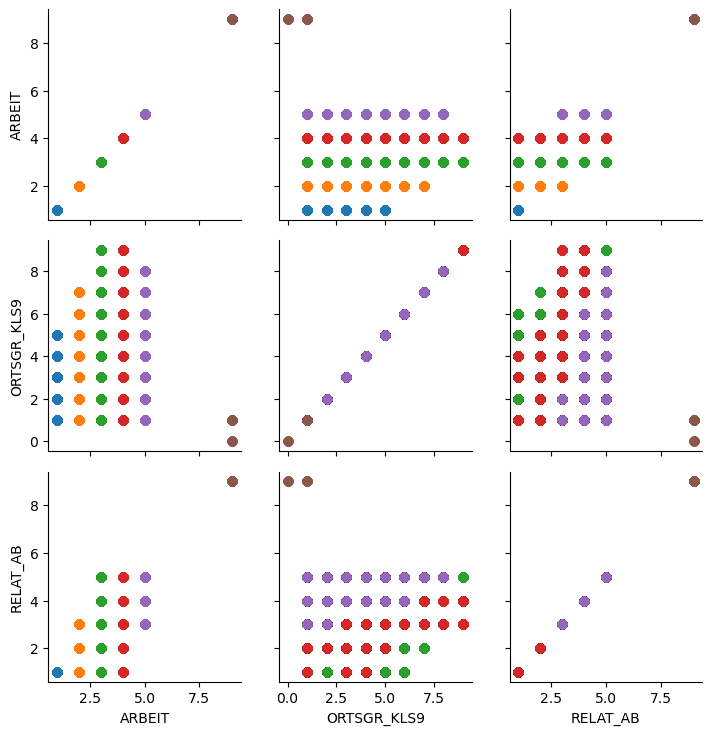

In [5]:
cols = feat_info.query('information_level == "community"')['attribute'].tolist()
d = azdias[cols]
g = sns.PairGrid(d,hue='ARBEIT',vars=cols)
g.map(plt.scatter)
plt.show()

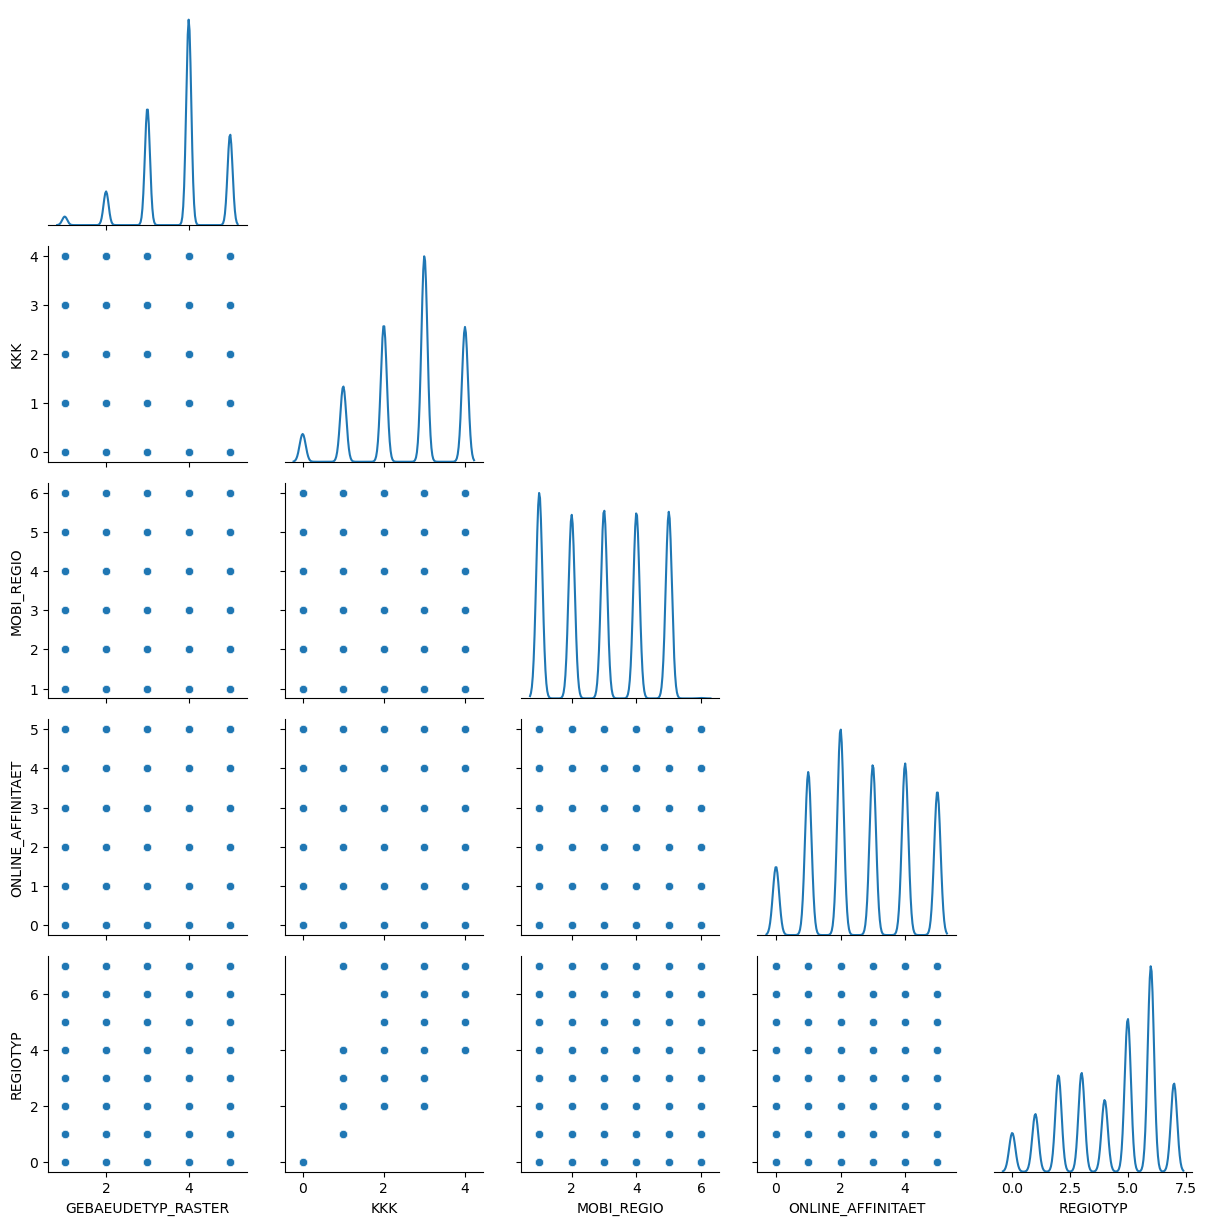

In [6]:
d = azdias[feat_info.query('information_level == "region_rr1"')['attribute'].tolist()]
g = sns.PairGrid(d , diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
plt.show()

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
def GetDistinctMissingValuesList(info_df):
    g = ()
    for i in np.unique(info_df.missing_or_unknown):
        i = i.replace('[','').replace(']','').split(',')
        for j in i:
            if j!='':  
                try:
                       g = (*g ,int(str(j)))
                except:
                       g = (*g ,str(j))

    g = tuple(set(g))
    return list(g)
def MissingListMask(df,info_df):
    '''missing Values Mask for columns'''
    m = GetDistinctMissingValuesList(info_df)
    m.insert(0,np.nan)
    d = pd.DataFrame(columns = m , index = df.columns)
    for i in df.columns:
        for j in m:
            s = df[i].isin([j]).sum()
            if s > 0 :
                d.loc[i,j] = True
    return d 

def RowStat(axis,df,info_df):
    g = GetDistinctMissingValuesList(info_df)
    missing = df.isin(g).sum(axis=axis)
    n = df.isin([np.nan]).sum(axis=axis)
    if axis == 1 : 
        t = info_df.attribute.shape[0]
    else:
        t = df.shape[0]
    d = {
          'MissingValue' : missing 
         , 'nanValue':n  
         , 'BadValue' : missing + n
         , 'GoodValue' : t - missing - n 
         , 'TotalValues' : t
        }
    Row_Col_Stat = pd.DataFrame(d)
    Row_Col_Stat['BadValuePercentage'] = (Row_Col_Stat.BadValue / Row_Col_Stat.TotalValues) * 100.0
    Row_Col_Stat['GoodValuePercentage'] = (Row_Col_Stat.GoodValue / Row_Col_Stat.TotalValues) * 100.0
    return Row_Col_Stat

def ScatterMissingValues(attr1 ,attr2,info_df):
    m = GetDistinctMissingValuesList(info_df)
    X = []
    Y = []
    for i in m:
        if str(i).isnumeric():
            e1 = attr1 + ' == ' + str(i)
            e2 = attr2 + ' == ' + str(i)
        else:
            e1 = attr1 + ' == "' + str(i)+'"'
            e2 = attr1 + ' == "' + str(i)+'"'
        l1 = azdias.query(e1)
        l2 =azdias.query(e2)
        if l1.shape[0] > 0 :
            X.append(l1[attr1].tolist())
            Y.append(l1[attr2].tolist())
        if l2.shape[0] > 0 :
            X.append(l2[attr1].tolist())
            Y.append(l2[attr2].tolist())
    return X ,Y
        
def ScatterPlot(ax , a ,b , df ,info_df):
    ax.scatter(df[cols[a]] , df[cols[b]] , c='b')
    X , Y  = ScatterMissingValues(cols[a],cols[b],info_df)
    for i in range(len(X)):
        ax.scatter(X[i],Y[i],c='r')
    ax.set_xlabel(cols[a])
    ax.set_ylabel(cols[b])
    ax.set_title('('+ cols[a] + ', '+cols[b]+') '+'Missing Values in RED')
    return ax
       

In [8]:
M_List = GetDistinctMissingValuesList(feat_info)
M_List.insert(0,np.nan)
print('List of Distinct Missing Values in DataFrame' , M_List)
Missing_List_Mask =MissingListMask(azdias,feat_info)
Missing_List_Mask['ColCategory'] = list(feat_info.information_level)
Missing_List_Mask

List of Distinct Missing Values in DataFrame [nan, 0, 9, 'XX', 'X', -1]


NaN     0     9   XX    X    -1     ColCategory
AGER_TYP               NaN  True   NaN  NaN  NaN  True          person
ALTERSKATEGORIE_GROB   NaN   NaN  True  NaN  NaN   NaN          person
ANREDE_KZ              NaN   NaN   NaN  NaN  NaN   NaN          person
CJT_GESAMTTYP         True   NaN   NaN  NaN  NaN   NaN          person
FINANZ_MINIMALIST      NaN   NaN   NaN  NaN  NaN   NaN          person
...                    ...   ...   ...  ...  ...   ...             ...
PLZ8_HHZ              True   NaN   NaN  NaN  NaN   NaN  macrocell_plz8
PLZ8_GBZ              True   NaN   NaN  NaN  NaN   NaN  macrocell_plz8
ARBEIT                True   NaN  True  NaN  NaN   NaN       community
ORTSGR_KLS9           True  True  True  NaN  NaN   NaN       community
RELAT_AB              True   NaN  True  NaN  NaN   NaN       community

[85 rows x 7 columns]

In [9]:
Row_Stat = RowStat(1,azdias,feat_info)
Row_Stat


MissingValue  nanValue  BadValue  GoodValue  TotalValues  \
0                  8        42        50         35           85   
1                 10         1        11         74           85   
2                  9         1        10         75           85   
3                 17         2        19         66           85   
4                  9         0         9         76           85   
...              ...       ...       ...        ...          ...   
891216            11         3        14         71           85   
891217            13         1        14         71           85   
891218            15         2        17         68           85   
891219            15         1        16         69           85   
891220            11         1        12         73           85   

        BadValuePercentage  GoodValuePercentage  
0                58.823529            41.176471  
1                12.941176            87.058824  
2                11.764706            88.235294  
3                22.352941            77.647059  
4                10.588235            89.411765  
...                    ...                  ...  
891216           16.470588            83.529412  
891217           16.470588            83.529412  
891218           20.000000            80.000000  
891219           18.823529            81.176471  
891220           14.117647            85.882353  

[891221 rows x 7 columns]

In [10]:
Col_Stat = RowStat(0,azdias,feat_info)
Col_Stat['ColCategory'] = list(feat_info.information_level)
Col_Stat

MissingValue  nanValue  BadValue  GoodValue  \
AGER_TYP                    685843         0    685843     205378   
ALTERSKATEGORIE_GROB          2881         0      2881     888340   
ANREDE_KZ                        0         0         0     891221   
CJT_GESAMTTYP                    0      4854      4854     886367   
FINANZ_MINIMALIST                0         0         0     891221   
...                            ...       ...       ...        ...   
PLZ8_HHZ                         0    116515    116515     774706   
PLZ8_GBZ                         0    116515    116515     774706   
ARBEIT                         159     97216     97375     793846   
ORTSGR_KLS9                  91937     97216    189153     702068   
RELAT_AB                       159     97216     97375     793846   

                      TotalValues  BadValuePercentage  GoodValuePercentage  \
AGER_TYP                   891221           76.955435            23.044565   
ALTERSKATEGORIE_GROB       891221            0.323264            99.676736   
ANREDE_KZ                  891221            0.000000           100.000000   
CJT_GESAMTTYP              891221            0.544646            99.455354   
FINANZ_MINIMALIST          891221            0.000000           100.000000   
...                           ...                 ...                  ...   
PLZ8_HHZ                   891221           13.073637            86.926363   
PLZ8_GBZ                   891221           13.073637            86.926363   
ARBEIT                     891221           10.926022            89.073978   
ORTSGR_KLS9                891221           21.224029            78.775971   
RELAT_AB                   891221           10.926022            89.073978   

                         ColCategory  
AGER_TYP                      person  
ALTERSKATEGORIE_GROB          person  
ANREDE_KZ                     person  
CJT_GESAMTTYP                 person  
FINANZ_MINIMALIST             person  
...                              ...  
PLZ8_HHZ              macrocell_plz8  
PLZ8_GBZ              macrocell_plz8  
ARBEIT                     community  
ORTSGR_KLS9                community  
RELAT_AB                   community  

[85 rows x 8 columns]

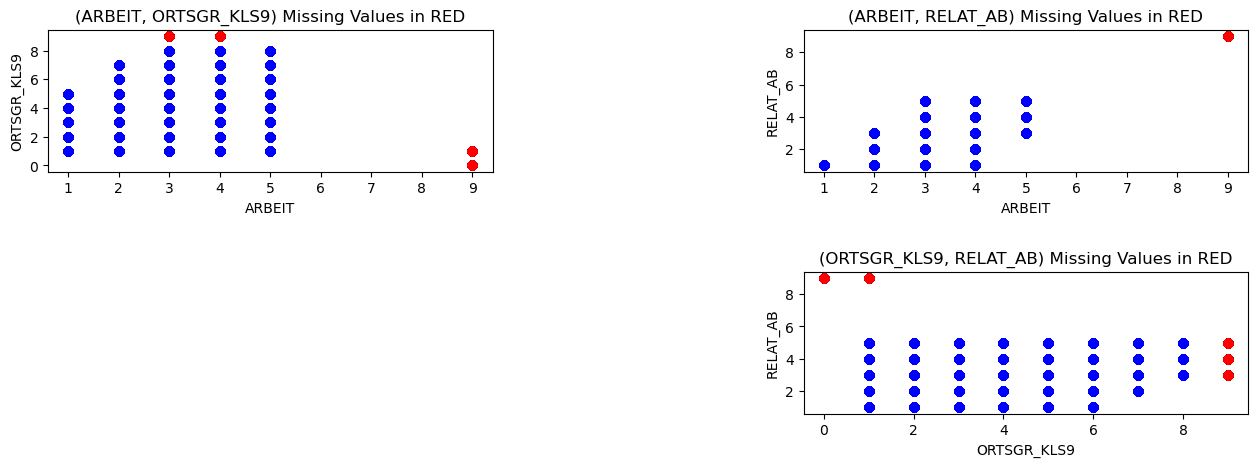

In [11]:
'''Identify Missing values in Scatter plot in RED'''
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.set_figwidth(15)
cols = feat_info.query('information_level == "community"')['attribute'].tolist()
        
ax1 = ScatterPlot(ax1,0,1,azdias,feat_info)
ax2 = ScatterPlot(ax2,0,2,azdias,feat_info)
ax3.set_visible(False)
ax4 = ScatterPlot(ax4,1,2,azdias,feat_info)
   
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.7, 
                    hspace=0.7)
plt.show()

In [12]:
Col_Stat.query('ColCategory == "community"')

MissingValue  nanValue  BadValue  GoodValue  TotalValues  \
ARBEIT                159     97216     97375     793846       891221   
ORTSGR_KLS9         91937     97216    189153     702068       891221   
RELAT_AB              159     97216     97375     793846       891221   

             BadValuePercentage  GoodValuePercentage ColCategory  
ARBEIT                10.926022            89.073978   community  
ORTSGR_KLS9           21.224029            78.775971   community  
RELAT_AB              10.926022            89.073978   community

<BarContainer object of 3 artists>

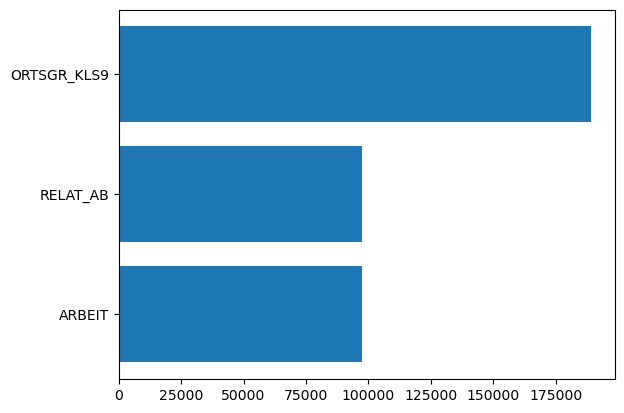

In [13]:
com = Col_Stat.query('ColCategory == "community"').sort_values('BadValue')
plt.barh(com.index.values,com.BadValue)

In [14]:
# 2 - Top 10 columns by number os rows wiht nan values
Col_Stat.sort_values('nanValue' , ascending=False).head(10)

MissingValue  nanValue  BadValue  GoodValue  TotalValues  \
KK_KUNDENTYP             0    584612    584612     306609       891221   
KBA05_GBZ                0    133324    133324     757897       891221   
KBA05_ANTG1         261049    133324    394373     496848       891221   
KBA05_ANTG3         511545    133324    644869     246352       891221   
MOBI_REGIO               0    133324    133324     757897       891221   
KBA05_ANTG2         292538    133324    425862     465359       891221   
KBA05_ANTG4         600171    133324    733495     157726       891221   
KBA05_BAUMAX        343200    133324    476524     414697       891221   
REGIOTYP             36868    121196    158064     733157       891221   
KKK                  36868    121196    158064     733157       891221   

              BadValuePercentage  GoodValuePercentage    ColCategory  
KK_KUNDENTYP           65.596749            34.403251      household  
KBA05_GBZ              14.959701            85.040299  microcell_rr3  
KBA05_ANTG1            44.250865            55.749135  microcell_rr3  
KBA05_ANTG3            72.357922            27.642078  microcell_rr3  
MOBI_REGIO             14.959701            85.040299     region_rr1  
KBA05_ANTG2            47.784107            52.215893  microcell_rr3  
KBA05_ANTG4            82.302257            17.697743  microcell_rr3  
KBA05_BAUMAX           53.468668            46.531332  microcell_rr3  
REGIOTYP               17.735668            82.264332     region_rr1  
KKK                    17.735668            82.264332     region_rr1

In [15]:
# Identify missing or unknown data values and convert them to NaNs.

def SetNan(df,feat_info):
    missing_list = GetDistinctMissingValuesList(feat_info)
    missing_filter_mask = df.isin(missing_list)
    for i in df.columns.values:
        df.loc[missing_filter_mask[i],i] = np.nan       

In [16]:
SetNan(azdias,feat_info)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(array([32., 34.,  3.,  1.,  3.,  2.,  1.,  3.,  2.,  4.]),
 array([     0. ,  88906.1, 177812.2, 266718.3, 355624.4, 444530.5,
        533436.6, 622342.7, 711248.8, 800154.9, 889061. ]),
 <BarContainer object of 10 artists>)

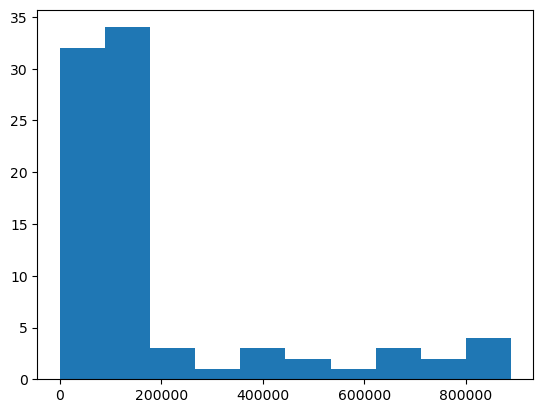

In [17]:
plt.hist(Col_Stat.BadValue,label=Col_Stat.index.values,bins = 10)

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# 1- Top 10 columns by number of rows wiht missing values 
Col_Stat.sort_values(['BadValuePercentage'] , ascending=False).head(10)

MissingValue  nanValue  BadValue  GoodValue  TotalValues  \
TITEL_KZ                815562     73499    889061       2160       891221   
ANZ_TITEL               814542     73499    888041       3180       891221   
SOHO_KZ                 810834     73499    884333       6888       891221   
ANZ_HH_TITEL            770278     97008    867286      23935       891221   
KBA05_ANTG4             600171    133324    733495     157726       891221   
GREEN_AVANTGARDE        715996         0    715996     175225       891221   
AGER_TYP                685843         0    685843     205378       891221   
KBA05_ANTG3             511545    133324    644869     246352       891221   
WOHNDAUER_2008          551176     73499    624675     266546       891221   
KK_KUNDENTYP                 0    584612    584612     306609       891221   

                  BadValuePercentage  GoodValuePercentage    ColCategory  
TITEL_KZ                   99.757636             0.242364         person  
ANZ_TITEL                  99.643186             0.356814      household  
SOHO_KZ                    99.227128             0.772872         person  
ANZ_HH_TITEL               97.314359             2.685641       building  
KBA05_ANTG4                82.302257            17.697743  microcell_rr3  
GREEN_AVANTGARDE           80.338771            19.661229         person  
AGER_TYP                   76.955435            23.044565         person  
KBA05_ANTG3                72.357922            27.642078  microcell_rr3  
WOHNDAUER_2008             70.092042            29.907958      household  
KK_KUNDENTYP               65.596749            34.403251      household

In [19]:
print("How many features shares the same missing value")
Missing_List_Mask.sum()

How many features shares the same missing value


NaN                                                           53
0                                                             33
9                                                             16
XX                                                             2
X                                                              1
-1                                                             4
ColCategory    personpersonpersonpersonpersonpersonpersonpers...
dtype: object

In [20]:
print(f'[Features/Column Names] Shares the Same Missing Value = [{ Missing_List_Mask.columns[1]}]')
Missing_List_Mask[Missing_List_Mask.iloc[:,1].fillna(False)][Missing_List_Mask.columns[1]].index.values



[Features/Column Names] Shares the Same Missing Value = [0]


array(['AGER_TYP', 'GEBURTSJAHR', 'GREEN_AVANTGARDE',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KKK',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'ORTSGR_KLS9'],
      dtype=object)

In [21]:
print("How many features shares the same missing value in [Person] category")
Missing_List_Mask.query('ColCategory == "person"').sum()

How many features shares the same missing value in [Person] category


NaN                                                           11
0                                                             12
9                                                              7
XX                                                             0
X                                                              0
-1                                                             4
ColCategory    personpersonpersonpersonpersonpersonpersonpers...
dtype: object

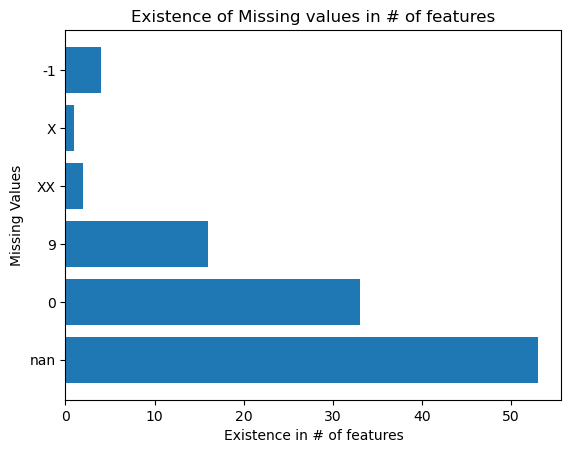

In [22]:
x = Missing_List_Mask.sum()[:-1].tolist()
y = Missing_List_Mask.sum()[:-1].index.values.tolist()
figure , ax = plt.subplots()
ax.barh([str(i) for i in y] , x)
ax.set_ylabel('Missing Values')
ax.set_xlabel("Existence in # of features")
ax.set_title("Existence of Missing values in # of features")
plt.show()

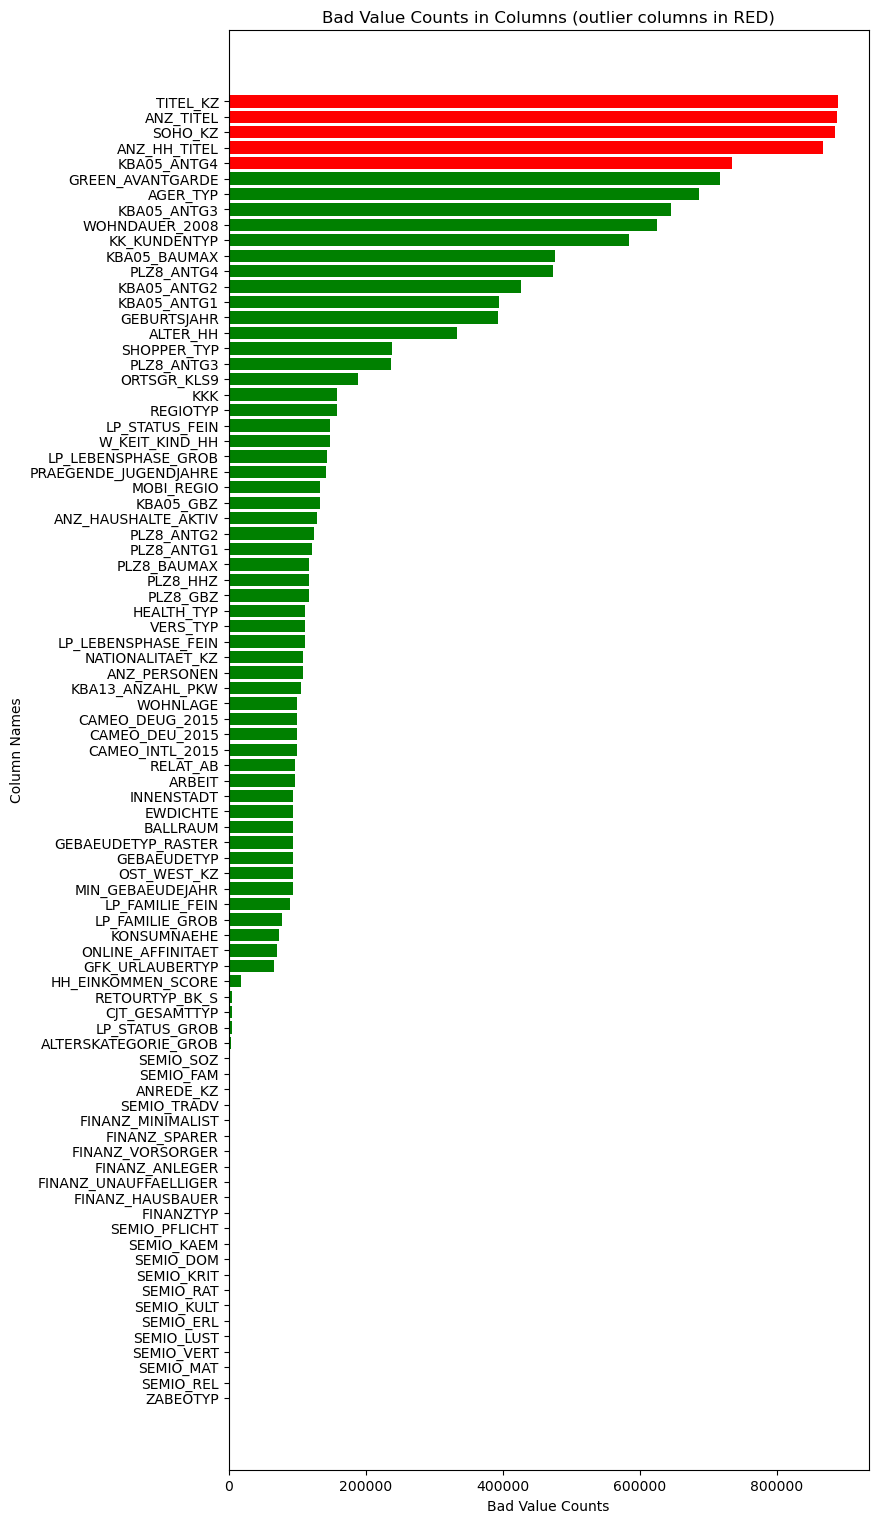

In [23]:
figure ,ax = plt.subplots()
ax.barh(Col_Stat.sort_values('BadValue',ascending=True).index.values , Col_Stat.sort_values('BadValue' ,ascending=True).BadValue , color='g')
ax.barh(Col_Stat.sort_values('BadValue',ascending=False).index.values[0:5] , Col_Stat.sort_values('BadValue',ascending=False).BadValue[0:5] , color='r')

ax.set_title("Bad Value Counts in Columns (outlier columns in RED)")
ax.set_xlabel("Bad Value Counts")
ax.set_ylabel("Column Names")
plt.subplots_adjust(left=0.0, right=1.0, bottom=2, top=5)
plt.show()

In [24]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
Columns_to_Drop = Col_Stat.sort_values('BadValuePercentage' , ascending = False).BadValue.head(5).index.values
azdias.drop(Columns_to_Drop,inplace = True, axis = 1)


In [25]:
print('Remove dropped columns from feat_info Row index')
Feat_info_index_to_drop = feat_info[feat_info.attribute.isin(Columns_to_Drop)].index.values.tolist()
feat_info_drop = feat_info
feat_info_drop = feat_info_drop.drop(Feat_info_index_to_drop, axis = 0)

Remove dropped columns from feat_info Row index


In [26]:
Columns_to_Drop

array(['TITEL_KZ', 'ANZ_TITEL', 'SOHO_KZ', 'ANZ_HH_TITEL', 'KBA05_ANTG4'],
      dtype=object)


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. 
Are there any patterns in missing values?

<br>
<li>Columns in the same level of information have similar percentage of missing values and some of them have the exact number of missing values.
</li>
<li>only one column uses -1 as its unknown value; X is used in one column and XX is used as unknown value in two columns most of the columns 53 uses nan as unknown values; then comes 33 columns uses 0 as unknown values and then 16 columns use 9 as unknown value.
</li>
<br>
Which columns were removed from the dataset?
<br>
<li>Top 5 columns with unkown or missing values percentage (Bad Values)</li>
['TITEL_KZ', 'ANZ_TITEL', 'SOHO_KZ', 'ANZ_HH_TITEL', 'KBA05_ANTG4']
)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [27]:
# Refresh Columns statistics DataFrame and Row Statistics DataFrame After Setting [unknown] values to [nan] 
Row_Stat = RowStat(1,azdias,feat_info)
Row_Stat
Col_Stat = RowStat(0,azdias,feat_info)
Col_Stat

MissingValue  nanValue  BadValue  GoodValue  \
AGER_TYP                         0    685843    685843     205378   
ALTERSKATEGORIE_GROB             0      2881      2881     888340   
ANREDE_KZ                        0         0         0     891221   
CJT_GESAMTTYP                    0      4854      4854     886367   
FINANZ_MINIMALIST                0         0         0     891221   
...                            ...       ...       ...        ...   
PLZ8_HHZ                         0    116515    116515     774706   
PLZ8_GBZ                         0    116515    116515     774706   
ARBEIT                           0     97375     97375     793846   
ORTSGR_KLS9                      0    189153    189153     702068   
RELAT_AB                         0     97375     97375     793846   

                      TotalValues  BadValuePercentage  GoodValuePercentage  
AGER_TYP                   891221           76.955435            23.044565  
ALTERSKATEGORIE_GROB       891221            0.323264            99.676736  
ANREDE_KZ                  891221            0.000000           100.000000  
CJT_GESAMTTYP              891221            0.544646            99.455354  
FINANZ_MINIMALIST          891221            0.000000           100.000000  
...                           ...                 ...                  ...  
PLZ8_HHZ                   891221           13.073637            86.926363  
PLZ8_GBZ                   891221           13.073637            86.926363  
ARBEIT                     891221           10.926022            89.073978  
ORTSGR_KLS9                891221           21.224029            78.775971  
RELAT_AB                   891221           10.926022            89.073978  

[80 rows x 7 columns]

In [28]:
# How much data is missing in each row of the dataset?
Row_Stat.BadValue

0         45
1          8
2          5
3         14
4          4
          ..
891216     9
891217    10
891218    12
891219    11
891220     8
Name: BadValue, Length: 891221, dtype: int64

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = '90'
GoodRows = azdias.iloc[Row_Stat.query('GoodValuePercentage > ' + threshold).index.values]
BadRows = azdias.iloc[Row_Stat.query('GoodValuePercentage <= ' + threshold).index.values]
G = GoodRows[Col_Stat.sort_values('GoodValue' , ascending=False).head(5).index.values.tolist()]
B = BadRows[Col_Stat.sort_values('GoodValue' , ascending=False).head(5).index.values.tolist()]

G2 = GoodRows[Col_Stat.sort_values('BadValue' , ascending=False).head(5).index.values.tolist()]
B2 = BadRows[Col_Stat.sort_values('BadValue' , ascending=False).head(5).index.values.tolist()]

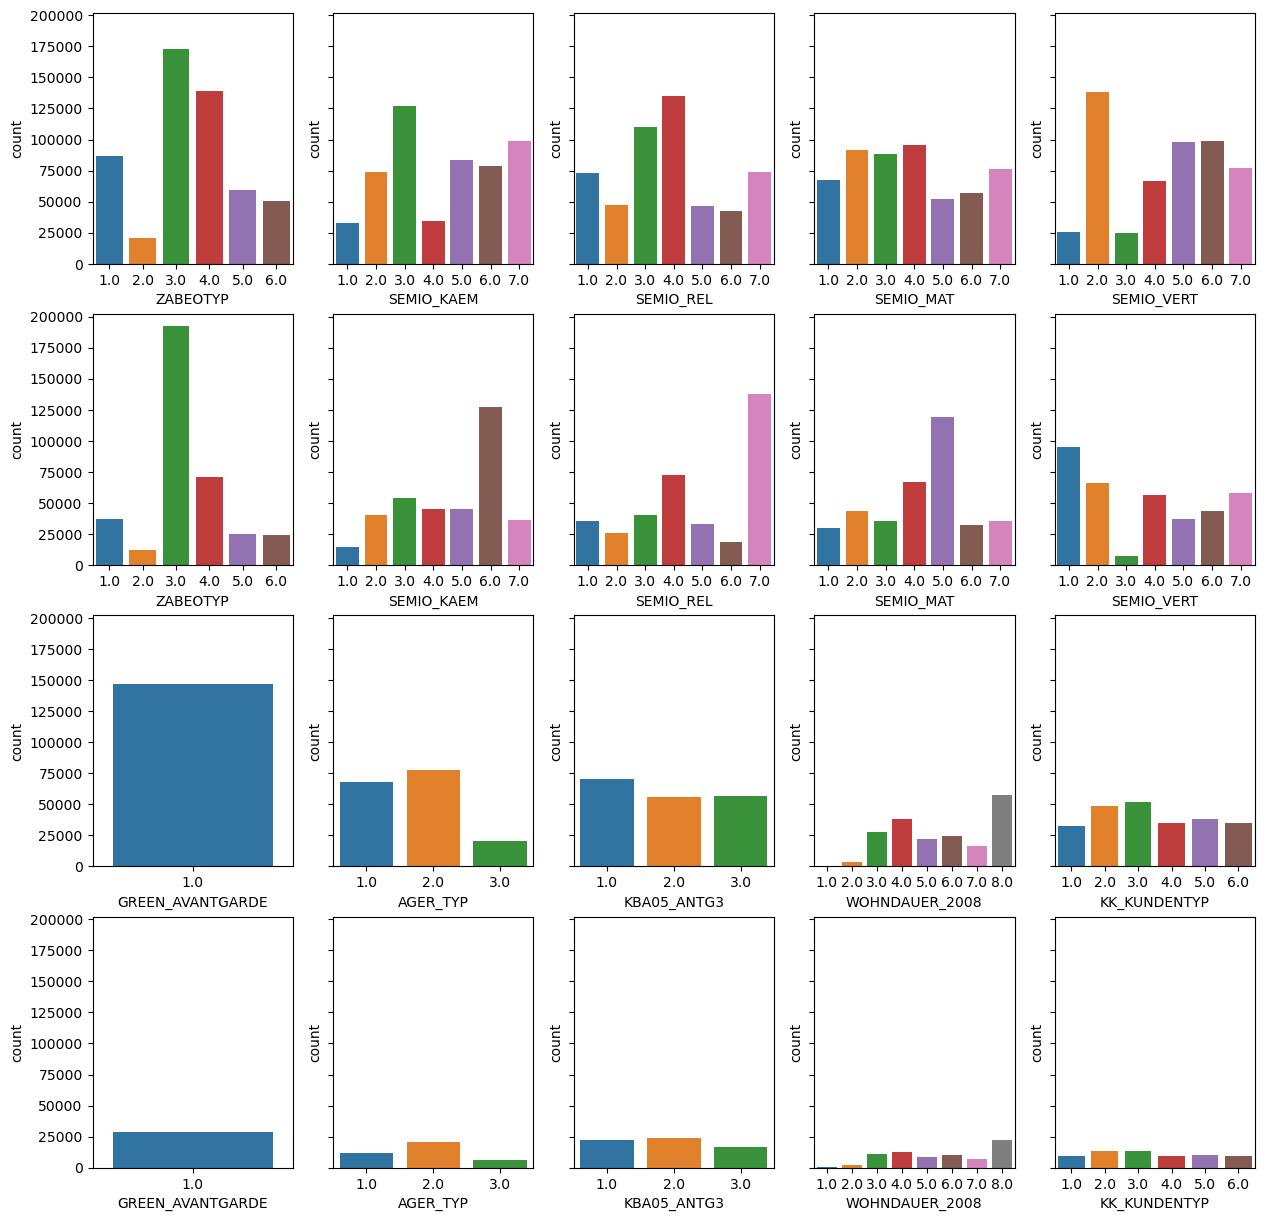

In [30]:
fig, ax = plt.subplots(4,5,figsize=(15, 15), sharey=True)
sns.countplot(ax= ax[0,0] ,x=G[G.columns.tolist()[0]])
sns.countplot(ax= ax[0,1] , x=G[G.columns.tolist()[1]])
sns.countplot(ax= ax[0,2] , x=G[G.columns.tolist()[2]])
sns.countplot(ax= ax[0,3] , x=G[G.columns.tolist()[3]])
sns.countplot(ax= ax[0,4] , x=G[G.columns.tolist()[4]])

sns.countplot(ax= ax[1,0] ,x=B[B.columns.tolist()[0]])
sns.countplot(ax= ax[1,1] , x=B[B.columns.tolist()[1]])
sns.countplot(ax= ax[1,2] , x=B[B.columns.tolist()[2]])
sns.countplot(ax= ax[1,3] , x=B[B.columns.tolist()[3]])
sns.countplot(ax= ax[1,4] , x=B[B.columns.tolist()[4]])

sns.countplot(ax= ax[2,0] ,x=G2[G2.columns.tolist()[0]])
sns.countplot(ax= ax[2,1] , x=G2[G2.columns.tolist()[1]])
sns.countplot(ax= ax[2,2] , x=G2[G2.columns.tolist()[2]])
sns.countplot(ax= ax[2,3] , x=G2[G2.columns.tolist()[3]])
sns.countplot(ax= ax[2,4] , x=G2[G2.columns.tolist()[4]])

sns.countplot(ax= ax[3,0] ,x=B2[B2.columns.tolist()[0]])
sns.countplot(ax= ax[3,1] , x=B2[B2.columns.tolist()[1]])
sns.countplot(ax= ax[3,2] , x=B2[B2.columns.tolist()[2]])
sns.countplot(ax= ax[3,3] , x=B2[B2.columns.tolist()[3]])
sns.countplot(ax= ax[3,4] , x=B2[B2.columns.tolist()[4]])
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?

<li> 
    the data with lots of missing values are NOT qualitatively different from data with few or no missing values %  
</li>)

In [31]:
Row_Stat.describe()

MissingValue       nanValue       BadValue      GoodValue  TotalValues  \
count      891221.0  891221.000000  891221.000000  891221.000000     891221.0   
mean            0.0      11.913773      11.913773      73.086227         85.0   
std             0.0      12.031895      12.031895      12.031895          0.0   
min             0.0       0.000000       0.000000      32.000000         85.0   
25%             0.0       6.000000       6.000000      74.000000         85.0   
50%             0.0       8.000000       8.000000      77.000000         85.0   
75%             0.0      11.000000      11.000000      79.000000         85.0   
max             0.0      53.000000      53.000000      85.000000         85.0   

       BadValuePercentage  GoodValuePercentage  
count       891221.000000        891221.000000  
mean            14.016204            85.983796  
std             14.155171            14.155171  
min              0.000000            37.647059  
25%              7.058824            87.058824  
50%              9.411765            90.588235  
75%             12.941176            92.941176  
max             62.352941           100.000000

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
# How many features are there of each data type?

feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [33]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

    
l = feat_info_drop.index.values.tolist() 
Cat = feat_info_drop.index.isin(l)
Cat = feat_info_drop[Cat]
Cat
d ={}
for i in Cat.attribute:
    if len(azdias[i].value_counts()) <= 2 :
        d[i] = 'binary'
    else:
        d[i] = 'multi-level'

level = pd.DataFrame.from_dict(d ,orient='index' , columns=['Level'])
level


Level
AGER_TYP              multi-level
ALTERSKATEGORIE_GROB  multi-level
ANREDE_KZ                  binary
CJT_GESAMTTYP         multi-level
FINANZ_MINIMALIST     multi-level
...                           ...
PLZ8_HHZ              multi-level
PLZ8_GBZ              multi-level
ARBEIT                multi-level
ORTSGR_KLS9           multi-level
RELAT_AB              multi-level

[80 rows x 1 columns]

In [34]:
# multi level and categorical 
def ColUniqueValueCheck():
    categortical_columns = feat_info_drop.attribute.tolist() 
    multilevel_columns = level.index.values
    l = pd.DataFrame(level.iloc[level.index.isin(list(filter(lambda x: x in categortical_columns, multilevel_columns))).tolist()])
    
    for i in feat_info_drop.attribute:
        l.loc[i,'InformationLevel'] = feat_info_drop.query('attribute == "'+i+'"')['type'].tolist()[0]
        l.loc[i,'UniqueValues'] = str(azdias[i].unique())
    return l
print("Check Columns Unique Values and Information Levels Before Decoding") 
l = ColUniqueValueCheck()
l

Check Columns Unique Values and Information Levels Before Decoding


Level InformationLevel  \
AGER_TYP              multi-level      categorical   
ALTERSKATEGORIE_GROB  multi-level          ordinal   
ANREDE_KZ                  binary      categorical   
CJT_GESAMTTYP         multi-level      categorical   
FINANZ_MINIMALIST     multi-level          ordinal   
...                           ...              ...   
PLZ8_HHZ              multi-level          ordinal   
PLZ8_GBZ              multi-level          ordinal   
ARBEIT                multi-level          ordinal   
ORTSGR_KLS9           multi-level          ordinal   
RELAT_AB              multi-level          ordinal   

                                               UniqueValues  
AGER_TYP                                  [nan  2.  3.  1.]  
ALTERSKATEGORIE_GROB                  [ 2.  1.  3.  4. nan]  
ANREDE_KZ                                           [1. 2.]  
CJT_GESAMTTYP                 [ 2.  5.  3.  4.  1.  6. nan]  
FINANZ_MINIMALIST                          [3. 1. 4. 2. 5.]  
...                                                     ...  
PLZ8_HHZ                          [nan  5.  4.  3.  2.  1.]  
PLZ8_GBZ                          [nan  4.  3.  5.  2.  1.]  
ARBEIT                            [nan  3.  2.  4.  1.  5.]  
ORTSGR_KLS9           [nan  5.  3.  6.  4.  8.  2.  7.  1.]  
RELAT_AB                          [nan  4.  2.  3.  5.  1.]  

[80 rows x 3 columns]

In [35]:
# Col stat for # multi level and categorical 
print('Check categorical columns Bad values percentages')
l.query('InformationLevel == "categorical" and Level == "multi-level"')


Check categorical columns Bad values percentages


Level InformationLevel  \
AGER_TYP          multi-level      categorical   
CJT_GESAMTTYP     multi-level      categorical   
FINANZTYP         multi-level      categorical   
GFK_URLAUBERTYP   multi-level      categorical   
LP_FAMILIE_FEIN   multi-level      categorical   
LP_FAMILIE_GROB   multi-level      categorical   
LP_STATUS_FEIN    multi-level      categorical   
LP_STATUS_GROB    multi-level      categorical   
NATIONALITAET_KZ  multi-level      categorical   
SHOPPER_TYP       multi-level      categorical   
ZABEOTYP          multi-level      categorical   
KK_KUNDENTYP      multi-level      categorical   
GEBAEUDETYP       multi-level      categorical   
CAMEO_DEUG_2015   multi-level      categorical   
CAMEO_DEU_2015    multi-level      categorical   

                                                       UniqueValues  
AGER_TYP                                          [nan  2.  3.  1.]  
CJT_GESAMTTYP                         [ 2.  5.  3.  4.  1.  6. nan]  
FINANZTYP                                       [4. 1. 6. 5. 2. 3.]  
GFK_URLAUBERTYP   [10.  1.  5. 12. nan  3.  8. 11.  4.  2.  7.  6.]  
LP_FAMILIE_FEIN       [ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.]  
LP_FAMILIE_GROB                           [ 2.  3.  1. nan  5.  4.]  
LP_STATUS_FEIN            [ 1.  2.  3. nan  4. 10.  5.  8.  6.  7.]  
LP_STATUS_GROB                            [ 1.  2.  4.  5.  3. nan]  
NATIONALITAET_KZ                                  [nan  1.  3.  2.]  
SHOPPER_TYP                                       [nan  3.  2.  1.]  
ZABEOTYP                                        [3. 5. 4. 1. 6. 2.]  
KK_KUNDENTYP                          [nan  1.  3.  6.  4.  2.  5.]  
GEBAEUDETYP                       [nan  8.  1.  3.  2.  6.  4.  5.]  
CAMEO_DEUG_2015           [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']  
CAMEO_DEU_2015    [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '...

In [36]:
# Re-encode categorical variable(s) to be kept in the analysis.
def ReEncodingCategoricalBinary(df):
    print('ReEncoding Categorical Binary varaibles ---> (Start)')
    print("="*120)
    print("Decode Column [OST_WEST_KZ]: ")
    print("="*120)
    print("Form List of Values : ", df.OST_WEST_KZ.unique())
    df.loc[azdias.OST_WEST_KZ == "O" , "OST_WEST_KZ"] = 0
    df.loc[azdias.OST_WEST_KZ == "W" , "OST_WEST_KZ"] = 1
    print("To List of Values" , df.OST_WEST_KZ.unique())
    print("="*120)
    print('ReEncoding Categorical Binary varaibles ---> (END)')
    
    
def ReEncodingCategoricalMultiLevel(df):
    print('ReEncoding Categorical multi level varaibles ---> (Start)')
    code = 0
    u = df.CAMEO_DEU_2015.unique()
    print("="*120)
    print("Decode Column [CAMEO_DEU_2015]: ")
    print("="*120)
    print("Form List of Values : ", u)
    for i in u:
        if pd.isna(i) : continue
        df.loc[df.CAMEO_DEU_2015.isin([i]),'CAMEO_DEU_2015'] = code
        code = code+1
    print("To List of Values" , df.CAMEO_DEU_2015.unique())

    code = 0
    u = df.CAMEO_DEUG_2015.unique()
    print("="*120)
    print("Decode Column [CAMEO_DEUG_2015]: ")
    print("="*120)
    print("From List of Values : " , u)
    for i in u:
        if pd.isna(i)  : continue
        df.loc[df.CAMEO_DEUG_2015.isin([i]),'CAMEO_DEUG_2015'] = code
        code = code+1


    print("To List of Values : " , df.CAMEO_DEUG_2015.unique())
    print("="*120)
    print('ReEncoding Categorical multi level varaibles <--- (END)')
    

#ReEncodingCategoricalBinary(azdias)
#ReEncodingCategoricalMultiLevel(azdias)


In [37]:
# Col stat for # multi level and categorical 
print('Check categorical columns unique Values After Decoding')
l = ColUniqueValueCheck()
l.query('InformationLevel == "categorical" and Level == "multi-level"')

Check categorical columns unique Values After Decoding


Level InformationLevel  \
AGER_TYP          multi-level      categorical   
CJT_GESAMTTYP     multi-level      categorical   
FINANZTYP         multi-level      categorical   
GFK_URLAUBERTYP   multi-level      categorical   
LP_FAMILIE_FEIN   multi-level      categorical   
LP_FAMILIE_GROB   multi-level      categorical   
LP_STATUS_FEIN    multi-level      categorical   
LP_STATUS_GROB    multi-level      categorical   
NATIONALITAET_KZ  multi-level      categorical   
SHOPPER_TYP       multi-level      categorical   
ZABEOTYP          multi-level      categorical   
KK_KUNDENTYP      multi-level      categorical   
GEBAEUDETYP       multi-level      categorical   
CAMEO_DEUG_2015   multi-level      categorical   
CAMEO_DEU_2015    multi-level      categorical   

                                                       UniqueValues  
AGER_TYP                                          [nan  2.  3.  1.]  
CJT_GESAMTTYP                         [ 2.  5.  3.  4.  1.  6. nan]  
FINANZTYP                                       [4. 1. 6. 5. 2. 3.]  
GFK_URLAUBERTYP   [10.  1.  5. 12. nan  3.  8. 11.  4.  2.  7.  6.]  
LP_FAMILIE_FEIN       [ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.]  
LP_FAMILIE_GROB                           [ 2.  3.  1. nan  5.  4.]  
LP_STATUS_FEIN            [ 1.  2.  3. nan  4. 10.  5.  8.  6.  7.]  
LP_STATUS_GROB                            [ 1.  2.  4.  5.  3. nan]  
NATIONALITAET_KZ                                  [nan  1.  3.  2.]  
SHOPPER_TYP                                       [nan  3.  2.  1.]  
ZABEOTYP                                        [3. 5. 4. 1. 6. 2.]  
KK_KUNDENTYP                          [nan  1.  3.  6.  4.  2.  5.]  
GEBAEUDETYP                       [nan  8.  1.  3.  2.  6.  4.  5.]  
CAMEO_DEUG_2015           [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']  
CAMEO_DEU_2015    [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '...

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

-Reencode OST_WEST_KZ and keept; replaced (O,W) by (0,1)
- CAMEO_DEU_2015 encoded with numbers
- CAMEO_DEUG_2015 encoded into numbers 


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [38]:
print('Check mixed columns')
l.query('InformationLevel == "mixed"')

Check mixed columns


Level InformationLevel  \
LP_LEBENSPHASE_FEIN    multi-level            mixed   
LP_LEBENSPHASE_GROB    multi-level            mixed   
PRAEGENDE_JUGENDJAHRE  multi-level            mixed   
WOHNLAGE               multi-level            mixed   
CAMEO_INTL_2015        multi-level            mixed   
KBA05_BAUMAX           multi-level            mixed   
PLZ8_BAUMAX            multi-level            mixed   

                                                            UniqueValues  
LP_LEBENSPHASE_FEIN    [15. 21.  3. nan 32.  8.  2.  5. 10.  4.  6. 2...  
LP_LEBENSPHASE_GROB    [ 4.  6.  1. nan 10.  2.  3.  5.  7. 12. 11.  8.]  
PRAEGENDE_JUGENDJAHRE  [nan 14. 15.  8.  3. 10. 11.  5.  6.  4.  2.  ...  
WOHNLAGE                               [nan  4.  2.  7.  3.  5.  1.  8.]  
CAMEO_INTL_2015        [nan '51' '24' '12' '43' '54' '22' '14' '13' '...  
KBA05_BAUMAX                                   [nan  5.  1.  2.  3.  4.]  
PLZ8_BAUMAX                                    [nan  1.  2.  4.  5.  3.]

In [39]:
Col_Stat[Col_Stat.index.isin(l.query('InformationLevel == "mixed"').index.values.tolist())]

MissingValue  nanValue  BadValue  GoodValue  \
LP_LEBENSPHASE_FEIN               0    110698    110698     780523   
LP_LEBENSPHASE_GROB               0    143510    143510     747711   
PRAEGENDE_JUGENDJAHRE             0    141734    141734     749487   
WOHNLAGE                          0    100098    100098     791123   
CAMEO_INTL_2015                   0     99352     99352     791869   
KBA05_BAUMAX                      0    476524    476524     414697   
PLZ8_BAUMAX                       0    116515    116515     774706   

                       TotalValues  BadValuePercentage  GoodValuePercentage  
LP_LEBENSPHASE_FEIN         891221           12.420937            87.579063  
LP_LEBENSPHASE_GROB         891221           16.102628            83.897372  
PRAEGENDE_JUGENDJAHRE       891221           15.903351            84.096649  
WOHNLAGE                    891221           11.231558            88.768442  
CAMEO_INTL_2015             891221           11.147852            88.852148  
KBA05_BAUMAX                891221           53.468668            46.531332  
PLZ8_BAUMAX                 891221           13.073637            86.926363

In [40]:
print("Feature Information number of features =" , feat_info_drop.shape[0])
print("Final DataFrame number of features =" , azdias.shape[1])

Feature Information number of features = 80
Final DataFrame number of features = 80


In [41]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def ReEngineer_PRAEGENDE_JUGENDJAHRE(df,df_info):
    # drop [PRAEGENDE_JUGENDJAHRE] and create new two features  
    #  [decade] new interval
    # [movement] new binary (mainstream vs. avantgarde)
    print('ReEngineer PRAEGENDE_JUGENDJAHRE varaible ---> (Start)')
    d_PRAEGENDE_JUGENDJAHRE = {
    '-1': 'unknown'
    ,'0': 'unknown'
    ,'1': '40s - war years (Mainstream, E+W)'
    ,'2': '40s - reconstruction years (Avantgarde, E+W)'
    ,'3': '50s - economic miracle (Mainstream, E+W)'
    ,'4': '50s - milk bar / Individualisation (Avantgarde, E+W)'
    ,'5': '60s - economic miracle (Mainstream, E+W)'
    ,'6': '60s - generation 68 / student protestors (Avantgarde, W)'
    ,'7': '60s - opponents to the building of the Wall (Avantgarde, E)'
    ,'8': '70s - family orientation (Mainstream, E+W)'
    ,'9': '70s - peace movement (Avantgarde, E+W)'
    ,'10': '80s - Generation Golf (Mainstream, W)'
    ,'11': '80s - ecological awareness (Avantgarde, W)'
    ,'12': '80s - FDJ / communist party youth organisation (Mainstream, E)'
    ,'13': '80s - Swords into ploughshares (Avantgarde, E)'
    ,'14': '90s - digital media kids (Mainstream, E+W)'
    ,'15': '90s - ecological awareness (Avantgarde, E+W)'

    }
    print("Data DataFrame Variables Before adding ['MOVMENT' , 'DECADE']= " , df.shape[1])
    print("Information DataFrame Variables Before adding ['MOVMENT' , 'DECADE'] =" , df_info.shape[0])
    Mainstream =[]
    Avantgarde =[]
    for key ,value in d_PRAEGENDE_JUGENDJAHRE.items():
        if 'Mainstream' in value:
            Mainstream.append(float(key))
        elif 'Avantgarde' in value:
            Avantgarde.append(float(key))
        decade =  value.split('s - ')[0] 
        if decade != 'unknown':
            df.loc[df.PRAEGENDE_JUGENDJAHRE.isin([float(key)]),"DECADE"]  =  float(decade)
                          
    df.loc[df.PRAEGENDE_JUGENDJAHRE.isin(Mainstream),"MOVMENT"]  = 1 #'M'   
    df.loc[df.PRAEGENDE_JUGENDJAHRE.isin(Avantgarde),"MOVMENT"]  = 2 #'A'  
    print("="*120)
    print("Adding new two columsn ['MOVMENT' , 'DECADE']")
    print("unique values in [MOVEMENT] " , df.MOVMENT.unique())
    print("unique values in [DECADE] " , df.DECADE.unique()) 
    print("="*120)
    print("Data DataFrame Variables After adding  ['MOVMENT' , 'DECADE']= " , df.shape[1])
    new_row = { "attribute":["MOVMENT" , "DECADE"] 
           ,"information_level" : [df_info.query('attribute == "PRAEGENDE_JUGENDJAHRE"').information_level.values[0]  
                                  ,df_info.query('attribute == "PRAEGENDE_JUGENDJAHRE"').information_level.values[0] ]
           ,"type" : ["binary" , "interval-type"]
           , "missing_or_unknown": [str(list(df.MOVMENT.unique())) , str(list(df.DECADE.unique()))]}
    new_row = pd.DataFrame(data=new_row)
    feat_drop = pd.concat([df_info , new_row] , ignore_index=True)
    df_info = feat_drop
    print("Information DataFrame Variables After adding ['MOVMENT' , 'DECADE'] =" , df_info.shape[0])
    print("="*120)
    print('ReEngineer PRAEGENDE_JUGENDJAHRE varaible ---> (END)')
    return df_info



In [42]:
print("Feature Information number of features =" , feat_info_drop.shape[0])
print("Final DataFrame number of features =" , azdias.shape[1])
feat_info_drop
new_row = { "attribute":["MOVMENT" , "DECADE"] 
           ,"information_level" : [feat_info_drop.query('attribute == "PRAEGENDE_JUGENDJAHRE"').information_level.values[0]  
                                  ,feat_info_drop.query('attribute == "PRAEGENDE_JUGENDJAHRE"').information_level.values[0] ]
           ,"type" : ["binary" , "interval-type"]
           , "missing_or_unknown": [str(list(azdias.PRAEGENDE_JUGENDJAHRE.unique())) , str(list(azdias.PRAEGENDE_JUGENDJAHRE.unique()))]}
new_row = pd.DataFrame(data=new_row)
feat_info_drop = pd.concat([feat_info_drop , new_row] , ignore_index=True)
feat_info_drop
print("Feature Information number of features =" , feat_info_drop.shape[0])
print("Final DataFrame number of features =" , azdias.shape[1])

Feature Information number of features = 80
Final DataFrame number of features = 80
Feature Information number of features = 82
Final DataFrame number of features = 80


In [43]:
print("Feature Information number of features =" , feat_info_drop.shape[0])
print("Final DataFrame number of features =" , azdias.shape[1])

Feature Information number of features = 82
Final DataFrame number of features = 80


In [44]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def ReEngineer_CAMEO_INTL_2015(df, df_info_):
    # drop [CAMEO_INTL_2015] and create new two features  
    #  [WEALTH] new ordinal
    # [LIFE_STAGE] ordinal
    print('ReEngineer CAMEO_INTL_2015 varaible ---> (Start)')
    d = {'-1': 'unknown'
    ,'11': 'Wealthy Households - Pre-Family Couples & Singles'
    ,'12': 'Wealthy Households - Young Couples With Children'
    ,'13': 'Wealthy Households - Families With School Age Children'
    ,'14': 'Wealthy Households - Older Families &  Mature Couples'
    ,'15': 'Wealthy Households - Elders In Retirement'
    ,'21': 'Prosperous Households - Pre-Family Couples & Singles'
    ,'22': 'Prosperous Households - Young Couples With Children'
    ,'23': 'Prosperous Households - Families With School Age Children'
    ,'24': 'Prosperous Households - Older Families & Mature Couples'
    ,'25': 'Prosperous Households - Elders In Retirement'
    ,'31': 'Comfortable Households - Pre-Family Couples & Singles'
    ,'32': 'Comfortable Households - Young Couples With Children'
    ,'33': 'Comfortable Households - Families With School Age Children'
    ,'34': 'Comfortable Households - Older Families & Mature Couples'
    ,'35': 'Comfortable Households - Elders In Retirement'
    ,'41': 'Less Affluent Households - Pre-Family Couples & Singles'
    ,'42': 'Less Affluent Households - Young Couples With Children'
    ,'43': 'Less Affluent Households - Families With School Age Children'
    ,'44': 'Less Affluent Households - Older Families & Mature Couples'
    ,'45': 'Less Affluent Households - Elders In Retirement'
    ,'51': 'Poorer Households - Pre-Family Couples & Singles'
    ,'52': 'Poorer Households - Young Couples With Children'
    ,'53': 'Poorer Households - Families With School Age Children'
    ,'54': 'Poorer Households - Older Families & Mature Couples'
    ,'55': 'Poorer Households - Elders In Retirement'
    ,'XX': 'unknown'
    }
    print("Data DataFrame variables Before adding ['WEALTH' , 'LIFE_STAGE']= " , df.shape[1])
    print("Information DataFrame variables Before adding['WEALTH' , 'LIFE_STAGE'] =" , df_info_.shape[0])
    for key ,value in d.items():
        if key in ['XX' , '-1']: 
            df.loc[df.CAMEO_INTL_2015.isin([key]),"WEALTH"] = np.nan
            df.loc[df.CAMEO_INTL_2015.isin([key]),"LIFE_STAGE"] = np .nan
        else:
            df.loc[df.CAMEO_INTL_2015.isin([key]),"WEALTH"]  = int(key[0])
            df.loc[df.CAMEO_INTL_2015.isin([key]),"LIFE_STAGE"]  = int(key[1]) 

    
    print("="*120)
    print("Adding new two columsn ['WEALTH' , 'LIFE_STAGE']")
    print("unique values in [WEALTH] " , df.WEALTH.unique())
    print("unique values in [LIFE_STAGE] " , df.LIFE_STAGE.unique()) 
    print("="*120)
    print("Data DataFrame variables after adding ['WEALTH' , 'LIFE_STAGE']= " , df.shape[1])
    
    new_row = { "attribute":["WEALTH" , "LIFE_STAGE"] 
           ,"information_level" : [df_info_.query('attribute == "CAMEO_INTL_2015"').information_level.values[0]  
                                  ,df_info_.query('attribute == "CAMEO_INTL_2015"').information_level.values[0] ]
           ,"type" : ["ordinal" , "ordinal"]
           , "missing_or_unknown": [str(list(df.WEALTH.unique())) , str(list(df.LIFE_STAGE.unique()))]}
    new_row = pd.DataFrame(data=new_row)
    info_drop = pd.concat([df_info_ , new_row] , ignore_index=True)
    df_info = info_drop
    print("Information DataFrame variables After adding['WEALTH' , 'LIFE_STAGE'] =" , df_info.shape[0])
    print("="*120)
    print('ReEngineer CAMEO_INTL_2015 varaible ---> (END)')
    
    return df_info
    

# we can drop KBA05_BAUMAX BAD Value % 53.46866
print('Remove dropped columns from feat_info and from azdias')


Remove dropped columns from feat_info and from azdias


In [45]:
print("Feature Information number of features =" , feat_info_drop.shape[0])
print("Final DataFrame number of features =" , azdias.shape[1])
feat_info_drop
new_row = { "attribute":["WEALTH" , "LIFE_STAGE"] 
           ,"information_level" : [feat_info_drop.query('attribute == "CAMEO_INTL_2015"').information_level.values[0]  
                                  ,feat_info_drop.query('attribute == "CAMEO_INTL_2015"').information_level.values[0] ]
           ,"type" : ["ordinal" , "ordinal"]
           , "missing_or_unknown": [str(list(azdias.CAMEO_INTL_2015.unique())) , str(list(azdias.CAMEO_INTL_2015.unique()))]}
new_row = pd.DataFrame(data=new_row)
feat_info_drop = pd.concat([feat_info_drop , new_row] , ignore_index=True)
feat_info_drop



Feature Information number of features = 82
Final DataFrame number of features = 80


attribute information_level           type  \
0               AGER_TYP            person    categorical   
1   ALTERSKATEGORIE_GROB            person        ordinal   
2              ANREDE_KZ            person    categorical   
3          CJT_GESAMTTYP            person    categorical   
4      FINANZ_MINIMALIST            person        ordinal   
..                   ...               ...            ...   
79              RELAT_AB         community        ordinal   
80               MOVMENT            person         binary   
81                DECADE            person  interval-type   
82                WEALTH     microcell_rr4        ordinal   
83            LIFE_STAGE     microcell_rr4        ordinal   

                                   missing_or_unknown  
0                                              [-1,0]  
1                                            [-1,0,9]  
2                                              [-1,0]  
3                                                 [0]  
4                                                [-1]  
..                                                ...  
79                                             [-1,9]  
80  [nan, 14.0, 15.0, 8.0, 3.0, 10.0, 11.0, 5.0, 6...  
81  [nan, 14.0, 15.0, 8.0, 3.0, 10.0, 11.0, 5.0, 6...  
82  [nan, '51', '24', '12', '43', '54', '22', '14'...  
83  [nan, '51', '24', '12', '43', '54', '22', '14'...  

[84 rows x 4 columns]

In [46]:
def DropReEngineeredColumns(df , fd_info):
    Columns_to_Drop = ['KBA05_BAUMAX' , 'PRAEGENDE_JUGENDJAHRE' , 'CAMEO_INTL_2015'] 
    df.drop(Columns_to_Drop , inplace = True,axis=1)
    Feat_info_index_to_drop = fd_info[fd_info.attribute.isin(Columns_to_Drop)].index.values.tolist()
    fd_info.drop(Feat_info_index_to_drop , inplace = True, axis = 0)
    print("Feature Information DataFrame # of Variabls =" , fd_info.shape[0])
    print("Data DataFrame # of Variabls = =" , df.shape[1])

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. <br>
Which ones did you keep
<li>LP_LEBENSPHASE_FEIN</li>
<li>LP_LEBENSPHASE_GROB</li>
<li>WOHNLAGE</li>
<li>PLZ8_BAUMAX</li>
, <br>which did you drop
<li>PRAEGENDE_JUGENDJAHRE</li>
<li>CAMEO_INTL_2015</li>
<li>KBA05_BAUMAX</li>
, <br>what engineering steps did you perform?
<li> # drop [CAMEO_INTL_2015] and create new two features  
    #  [WEALTH] new ordinal
    # [LIFE_STAGE] ordinal</li>
<li> # drop [PRAEGENDE_JUGENDJAHRE] and create new two features  
    #  [decade] new interval
    # [movement] new binary (mainstream vs. avantgarde)</li>
)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [47]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

feat_info_drop

attribute information_level           type  \
0               AGER_TYP            person    categorical   
1   ALTERSKATEGORIE_GROB            person        ordinal   
2              ANREDE_KZ            person    categorical   
3          CJT_GESAMTTYP            person    categorical   
4      FINANZ_MINIMALIST            person        ordinal   
..                   ...               ...            ...   
79              RELAT_AB         community        ordinal   
80               MOVMENT            person         binary   
81                DECADE            person  interval-type   
82                WEALTH     microcell_rr4        ordinal   
83            LIFE_STAGE     microcell_rr4        ordinal   

                                   missing_or_unknown  
0                                              [-1,0]  
1                                            [-1,0,9]  
2                                              [-1,0]  
3                                                 [0]  
4                                                [-1]  
..                                                ...  
79                                             [-1,9]  
80  [nan, 14.0, 15.0, 8.0, 3.0, 10.0, 11.0, 5.0, 6...  
81  [nan, 14.0, 15.0, 8.0, 3.0, 10.0, 11.0, 5.0, 6...  
82  [nan, '51', '24', '12', '43', '54', '22', '14'...  
83  [nan, '51', '24', '12', '43', '54', '22', '14'...  

[84 rows x 4 columns]

In [48]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#Reload the Data to test the cleaning function
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')


In [49]:
def GetDistinctMissingValuesList(info_df):
    g = ()
    for i in np.unique(info_df.missing_or_unknown):
        i = i.replace('[','').replace(']','').split(',')
        for j in i:
            if j!='':  
                try:
                       g = (*g ,int(str(j)))
                except:
                       g = (*g ,str(j))

    g = tuple(set(g))
    return list(g)

def RowStat(axis,df,info_df):
    g = GetDistinctMissingValuesList(info_df)
    missing = df.isin(g).sum(axis=axis)
    n = df.isin([np.nan]).sum(axis=axis)
    if axis == 1 : 
        t = info_df.attribute.shape[0]
    else:
        t = df.shape[0]
    d = {
          'MissingValue' : missing 
         , 'nanValue':n  
         , 'BadValue' : missing + n
         , 'GoodValue' : t - missing - n 
         , 'TotalValues' : t
        }
    Row_Col_Stat = pd.DataFrame(d)
    Row_Col_Stat['BadValuePercentage'] = (Row_Col_Stat.BadValue / Row_Col_Stat.TotalValues) * 100.0
    Row_Col_Stat['GoodValuePercentage'] = (Row_Col_Stat.GoodValue / Row_Col_Stat.TotalValues) * 100.0
    return Row_Col_Stat

# Identify missing or unknown data values and convert them to NaNs.

def SetNan(df,feat_info):
    missing_list = GetDistinctMissingValuesList(feat_info)
    missing_filter_mask = df.isin(missing_list)
    for i in df.columns.values:
        df.loc[missing_filter_mask[i],i] = np.nan

# Re-encode categorical variable(s) to be kept in the analysis.
def ReEncodingCategoricalBinary(df):
    print('ReEncoding Categorical Binary varaibles ---> (Start)')
    print("="*120)
    print("Decode Column [OST_WEST_KZ]: ")
    print("="*120)
    print("Form List of Values : ", df.OST_WEST_KZ.unique())
    df.loc[df.OST_WEST_KZ == "O" , "OST_WEST_KZ"] = 0
    df.loc[df.OST_WEST_KZ == "W" , "OST_WEST_KZ"] = 1
    print("To List of Values" , df.OST_WEST_KZ.unique())
    print("="*120)
    print('ReEncoding Categorical Binary varaibles ---> (END)')
    
    
def ReEncodingCategoricalMultiLevel(df):
    print('ReEncoding Categorical multi level varaibles ---> (Start)')
    code = 0
    u = df.CAMEO_DEU_2015.unique()
    print("="*120)
    print("Decode Column [CAMEO_DEU_2015]: ")
    print("="*120)
    print("Form List of Values : ", u)
    for i in u:
        if pd.isna(i) : continue
        df.loc[df.CAMEO_DEU_2015.isin([i]),'CAMEO_DEU_2015'] = code
        code = code+1
    print("To List of Values" , df.CAMEO_DEU_2015.unique())

    code = 0
    u = df.CAMEO_DEUG_2015.unique()
    print("="*120)
    print("Decode Column [CAMEO_DEUG_2015]: ")
    print("="*120)
    print("From List of Values : " , u)
    for i in u:
        if pd.isna(i)  : continue
        df.loc[df.CAMEO_DEUG_2015.isin([i]),'CAMEO_DEUG_2015'] = code
        code = code+1


    print("To List of Values : " , df.CAMEO_DEUG_2015.unique())
    print("="*120)
    print('ReEncoding Categorical multi level varaibles <--- (END)')
    
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def ReEngineer_PRAEGENDE_JUGENDJAHRE(df,df_info):
    # drop [PRAEGENDE_JUGENDJAHRE] and create new two features  
    #  [decade] new interval
    # [movement] new binary (mainstream vs. avantgarde)
    print('ReEngineer PRAEGENDE_JUGENDJAHRE varaible ---> (Start)')
    d_PRAEGENDE_JUGENDJAHRE = {
    '-1': 'unknown'
    ,'0': 'unknown'
    ,'1': '40s - war years (Mainstream, E+W)'
    ,'2': '40s - reconstruction years (Avantgarde, E+W)'
    ,'3': '50s - economic miracle (Mainstream, E+W)'
    ,'4': '50s - milk bar / Individualisation (Avantgarde, E+W)'
    ,'5': '60s - economic miracle (Mainstream, E+W)'
    ,'6': '60s - generation 68 / student protestors (Avantgarde, W)'
    ,'7': '60s - opponents to the building of the Wall (Avantgarde, E)'
    ,'8': '70s - family orientation (Mainstream, E+W)'
    ,'9': '70s - peace movement (Avantgarde, E+W)'
    ,'10': '80s - Generation Golf (Mainstream, W)'
    ,'11': '80s - ecological awareness (Avantgarde, W)'
    ,'12': '80s - FDJ / communist party youth organisation (Mainstream, E)'
    ,'13': '80s - Swords into ploughshares (Avantgarde, E)'
    ,'14': '90s - digital media kids (Mainstream, E+W)'
    ,'15': '90s - ecological awareness (Avantgarde, E+W)'

    }
    print("Data DataFrame Variables Before adding ['MOVMENT' , 'DECADE']= " , df.shape[1])
    print("Information DataFrame Variables Before adding ['MOVMENT' , 'DECADE'] =" , df_info.shape[0])
    Mainstream =[]
    Avantgarde =[]
    for key ,value in d_PRAEGENDE_JUGENDJAHRE.items():
        if 'Mainstream' in value:
            Mainstream.append(float(key))
        elif 'Avantgarde' in value:
            Avantgarde.append(float(key))
        decade =  value.split('s - ')[0] 
        if decade != 'unknown':
            df.loc[df.PRAEGENDE_JUGENDJAHRE.isin([float(key)]),"DECADE"]  =  float(decade)
                          
    df.loc[df.PRAEGENDE_JUGENDJAHRE.isin(Mainstream),"MOVMENT"]  = 1 #'M'   
    df.loc[df.PRAEGENDE_JUGENDJAHRE.isin(Avantgarde),"MOVMENT"]  = 2 #'A'  
    print("="*120)
    print("Adding new two columsn ['MOVMENT' , 'DECADE']")
    print("unique values in [MOVEMENT] " , df.MOVMENT.unique())
    print("unique values in [DECADE] " , df.DECADE.unique()) 
    print("="*120)
    print("Data DataFrame Variables After adding  ['MOVMENT' , 'DECADE']= " , df.shape[1])
    new_row = { "attribute":["MOVMENT" , "DECADE"] 
           ,"information_level" : [df_info.query('attribute == "PRAEGENDE_JUGENDJAHRE"').information_level.values[0]  
                                  ,df_info.query('attribute == "PRAEGENDE_JUGENDJAHRE"').information_level.values[0] ]
           ,"type" : ["binary" , "interval-type"]
           , "missing_or_unknown": [str(list(df.MOVMENT.unique())) , str(list(df.DECADE.unique()))]}
    new_row = pd.DataFrame(data=new_row)
    feat_drop = pd.concat([df_info , new_row] , ignore_index=True)
    df_info = feat_drop
    print("Information DataFrame Variables After adding ['MOVMENT' , 'DECADE'] =" , df_info.shape[0])
    print("="*120)
    print('ReEngineer PRAEGENDE_JUGENDJAHRE varaible ---> (END)')
    return df_info

# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def ReEngineer_CAMEO_INTL_2015(df, df_info_):
    # drop [CAMEO_INTL_2015] and create new two features  
    #  [WEALTH] new ordinal
    # [LIFE_STAGE] ordinal
    print('ReEngineer CAMEO_INTL_2015 varaible ---> (Start)')
    d = {'-1': 'unknown'
    ,'11': 'Wealthy Households - Pre-Family Couples & Singles'
    ,'12': 'Wealthy Households - Young Couples With Children'
    ,'13': 'Wealthy Households - Families With School Age Children'
    ,'14': 'Wealthy Households - Older Families &  Mature Couples'
    ,'15': 'Wealthy Households - Elders In Retirement'
    ,'21': 'Prosperous Households - Pre-Family Couples & Singles'
    ,'22': 'Prosperous Households - Young Couples With Children'
    ,'23': 'Prosperous Households - Families With School Age Children'
    ,'24': 'Prosperous Households - Older Families & Mature Couples'
    ,'25': 'Prosperous Households - Elders In Retirement'
    ,'31': 'Comfortable Households - Pre-Family Couples & Singles'
    ,'32': 'Comfortable Households - Young Couples With Children'
    ,'33': 'Comfortable Households - Families With School Age Children'
    ,'34': 'Comfortable Households - Older Families & Mature Couples'
    ,'35': 'Comfortable Households - Elders In Retirement'
    ,'41': 'Less Affluent Households - Pre-Family Couples & Singles'
    ,'42': 'Less Affluent Households - Young Couples With Children'
    ,'43': 'Less Affluent Households - Families With School Age Children'
    ,'44': 'Less Affluent Households - Older Families & Mature Couples'
    ,'45': 'Less Affluent Households - Elders In Retirement'
    ,'51': 'Poorer Households - Pre-Family Couples & Singles'
    ,'52': 'Poorer Households - Young Couples With Children'
    ,'53': 'Poorer Households - Families With School Age Children'
    ,'54': 'Poorer Households - Older Families & Mature Couples'
    ,'55': 'Poorer Households - Elders In Retirement'
    ,'XX': 'unknown'
    }
    print("Data DataFrame variables Before adding ['WEALTH' , 'LIFE_STAGE']= " , df.shape[1])
    print("Information DataFrame variables Before adding['WEALTH' , 'LIFE_STAGE'] =" , df_info_.shape[0])
    for key ,value in d.items():
        if key in ['XX' , '-1']: 
            df.loc[df.CAMEO_INTL_2015.isin([key]),"WEALTH"] = np.nan
            df.loc[df.CAMEO_INTL_2015.isin([key]),"LIFE_STAGE"] = np .nan
        else:
            df.loc[df.CAMEO_INTL_2015.isin([key]),"WEALTH"]  = int(key[0])
            df.loc[df.CAMEO_INTL_2015.isin([key]),"LIFE_STAGE"]  = int(key[1]) 

    
    print("="*120)
    print("Adding new two columsn ['WEALTH' , 'LIFE_STAGE']")
    print("unique values in [WEALTH] " , df.WEALTH.unique())
    print("unique values in [LIFE_STAGE] " , df.LIFE_STAGE.unique()) 
    print("="*120)
    print("Data DataFrame variables after adding ['WEALTH' , 'LIFE_STAGE']= " , df.shape[1])
    
    new_row = { "attribute":["WEALTH" , "LIFE_STAGE"] 
           ,"information_level" : [df_info_.query('attribute == "CAMEO_INTL_2015"').information_level.values[0]  
                                  ,df_info_.query('attribute == "CAMEO_INTL_2015"').information_level.values[0] ]
           ,"type" : ["ordinal" , "ordinal"]
           , "missing_or_unknown": [str(list(df.WEALTH.unique())) , str(list(df.LIFE_STAGE.unique()))]}
    new_row = pd.DataFrame(data=new_row)
    info_drop = pd.concat([df_info_ , new_row] , ignore_index=True)
    df_info = info_drop
    print("Information DataFrame variables After adding['WEALTH' , 'LIFE_STAGE'] =" , df_info.shape[0])
    print("="*120)
    print('ReEngineer CAMEO_INTL_2015 varaible ---> (END)')
    
    return df_info

def DropReEngineeredColumns(df , fd_info):
    Columns_to_Drop = ['KBA05_BAUMAX' , 'PRAEGENDE_JUGENDJAHRE' , 'CAMEO_INTL_2015'] 
    df.drop(Columns_to_Drop , inplace = True,axis=1)
    Feat_info_index_to_drop = fd_info[fd_info.attribute.isin(Columns_to_Drop)].index.values.tolist()
    fd_info.drop(Feat_info_index_to_drop , inplace = True, axis = 0)
    print("Feature Information DataFrame # of Variabls =" , fd_info.shape[0])
    print("Data DataFrame # of Variabls = =" , df.shape[1])
    

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [50]:
def clean_data(df , df_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    print('Prepare Row and column Stats for DataFrame --> (START)')
    Col_Stat = RowStat(0,df,df_info)
    Row_Stat =RowStat(1,df,df_info)
    print('Prepare Row and column Stats for DataFrame <-- (END)')
    
    print('Set NaN Values for all unkown Values in DataFrame --> (START)')
    SetNan(df,df_info)
    print('Set NaN Values for all unkown Values in DataFrame <-- (END)')
    
    # remove selected columns and rows, ...
    print('Remove selected columns --> (START)')
    
    
    Columns_to_Drop = Col_Stat.sort_values('BadValuePercentage' , ascending = False).BadValue.head(5).index.values
    print('Drop Columns : ', Columns_to_Drop , ' From Data DataFrame')
    df.drop(Columns_to_Drop,inplace = True, axis = 1)
    
    print('Drop Columns :', Columns_to_Drop , ' From Information DataFrame')
    Feat_info_index_to_drop = df_info[df_info.attribute.isin(Columns_to_Drop)].index.values.tolist()
    df_info.drop(Feat_info_index_to_drop , inplace = True , axis = 0)
    print('Remove selected columns --> (END)')
    
    print('Remove selected Rows with [BadValuePercentage >= 80]  --> (START)')
    Rows_to_Drop = Row_Stat.query('BadValuePercentage >= 80').sort_values('BadValuePercentage' , ascending = False).BadValue.index.values
    df.drop(Rows_to_Drop,inplace = True, axis = 0)
    print('Remove selected Rows with [BadValuePercentage >= 80]  <-- (END)')
    
    # select, re-encode, and engineer column values.
    ReEncodingCategoricalBinary(df)
    ReEncodingCategoricalMultiLevel(df)
    
    df_info = ReEngineer_PRAEGENDE_JUGENDJAHRE(df,df_info)
    df_info = ReEngineer_CAMEO_INTL_2015(df, df_info)
    DropReEngineeredColumns(df , df_info)
    
    
    # Return the cleaned dataframe.
    return df , df_info , Col_Stat , Row_Stat
    
    

In [51]:
df_info = feat_info.copy()
df = azdias.copy()
df , df_info , Col_Stat , Row_Stat = clean_data(df,df_info)

Prepare Row and column Stats for DataFrame --> (START)
Prepare Row and column Stats for DataFrame <-- (END)
Set NaN Values for all unkown Values in DataFrame --> (START)
Set NaN Values for all unkown Values in DataFrame <-- (END)
Remove selected columns --> (START)
Drop Columns :  ['TITEL_KZ' 'ANZ_TITEL' 'SOHO_KZ' 'ANZ_HH_TITEL' 'KBA05_ANTG4']  From Data DataFrame
Drop Columns : ['TITEL_KZ' 'ANZ_TITEL' 'SOHO_KZ' 'ANZ_HH_TITEL' 'KBA05_ANTG4']  From Information DataFrame
Remove selected columns --> (END)
Remove selected Rows with [BadValuePercentage >= 80]  --> (START)
Remove selected Rows with [BadValuePercentage >= 80]  <-- (END)
ReEncoding Categorical Binary varaibles ---> (Start)
Decode Column [OST_WEST_KZ]: 
Form List of Values :  [nan 'W' 'O']
To List of Values [nan 1 0]
ReEncoding Categorical Binary varaibles ---> (END)
ReEncoding Categorical multi level varaibles ---> (Start)
Decode Column [CAMEO_DEU_2015]: 
Form List of Values :  [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E'

In [52]:
print('List of new columns added')
print(df_info.attribute[np.invert( df_info.attribute.isin(feat_info.attribute.unique().tolist()))])
print('')
print('List of Columns Removed')
print(feat_info.attribute[np.invert( feat_info.attribute.isin(df_info.attribute.unique().tolist()))])

List of new columns added
80       MOVMENT
81        DECADE
82        WEALTH
83    LIFE_STAGE
Name: attribute, dtype: object

List of Columns Removed
22    PRAEGENDE_JUGENDJAHRE
39                  SOHO_KZ
40                 TITEL_KZ
45                ANZ_TITEL
51             ANZ_HH_TITEL
59          CAMEO_INTL_2015
63              KBA05_ANTG4
64             KBA05_BAUMAX
Name: attribute, dtype: object


In [53]:

print('='*120)
print('Step 1: Preprocessing :- NoteBook First Part Cleaning Result/Impact')
print('='*120)
print('* NAN and UNKNOWN Stats on ORIGINAL DataFrame *')
values_in_DataFrame = Col_Stat.shape[0] * Row_Stat.shape[0]
nan_Values_in_DataFrame = Col_Stat.nanValue.sum()
missing_Values_in_DataFrame = Col_Stat.BadValue.sum()
print(f'Out of {values_in_DataFrame} Values in Data DataFrame'
      ,f' ; There are {nan_Values_in_DataFrame} NAN Values' 
      ,f';  i.e. % of NAN in this DataFrame = {np.round((nan_Values_in_DataFrame / values_in_DataFrame ) * 100 ,2)}%'  )

print(f'Out of {values_in_DataFrame} Values in Data DataFrame'
      ,f' ; There are {missing_Values_in_DataFrame} NAN or UNKNOWN Values (Bad Values)' 
      ,f';  i.e. % of Bad Values in this DataFrame = {np.round((missing_Values_in_DataFrame / values_in_DataFrame ) * 100 ,2)}%'  )

print('Re Calculate Stats on the new DataFrame after PART one Cleaning')
Col_Stat = RowStat(0,df,df_info)
Row_Stat =RowStat(1,df,df_info)
print(' * NAN and UNKNOWN Stats on NEW DataFrame *')
values_in_DataFrame = Col_Stat.shape[0] * Row_Stat.shape[0]
nan_Values_in_DataFrame = Col_Stat.nanValue.sum()
missing_Values_in_DataFrame = Col_Stat.BadValue.sum()
print(f'Out of {values_in_DataFrame} Values in Data DataFrame'
      ,f' ; There are {nan_Values_in_DataFrame} NAN Values' 
      ,f';  i.e. % of NAN in this DataFrame = {np.round((nan_Values_in_DataFrame / values_in_DataFrame ) * 100 ,2)}%'  )
print(f'Out of {values_in_DataFrame} Values in Data DataFrame'
      ,f' ; There are {missing_Values_in_DataFrame} NAN or Unknown Values (Bad Values)' 
      ,f';  i.e. % of Bad Values in this DataFrame = {np.round((missing_Values_in_DataFrame / values_in_DataFrame ) * 100 ,2)}%'  )
Col_Stat

Step 1: Preprocessing :- NoteBook First Part Cleaning Result/Impact
* NAN and UNKNOWN Stats on ORIGINAL DataFrame *
Out of 75753785 Values in Data DataFrame  ; There are 4896838 NAN Values ;  i.e. % of NAN in this DataFrame = 6.46%
Out of 75753785 Values in Data DataFrame  ; There are 14880021 NAN or UNKNOWN Values (Bad Values) ;  i.e. % of Bad Values in this DataFrame = 19.64%
Re Calculate Stats on the new DataFrame after PART one Cleaning
 * NAN and UNKNOWN Stats on NEW DataFrame *
Out of 72188901 Values in Data DataFrame  ; There are 10382367 NAN Values ;  i.e. % of NAN in this DataFrame = 14.38%
Out of 72188901 Values in Data DataFrame  ; There are 10766384 NAN or Unknown Values (Bad Values) ;  i.e. % of Bad Values in this DataFrame = 14.91%


MissingValue  nanValue  BadValue  GoodValue  \
AGER_TYP                         0    685843    685843     205378   
ALTERSKATEGORIE_GROB             0      2881      2881     888340   
ANREDE_KZ                        0         0         0     891221   
CJT_GESAMTTYP                    0      4854      4854     886367   
FINANZ_MINIMALIST                0         0         0     891221   
...                            ...       ...       ...        ...   
RELAT_AB                         0     97375     97375     793846   
DECADE                           0    141734    141734     749487   
MOVMENT                          0    141734    141734     749487   
WEALTH                           0     99352     99352     791869   
LIFE_STAGE                       0     99352     99352     791869   

                      TotalValues  BadValuePercentage  GoodValuePercentage  
AGER_TYP                   891221           76.955435            23.044565  
ALTERSKATEGORIE_GROB       891221            0.323264            99.676736  
ANREDE_KZ                  891221            0.000000           100.000000  
CJT_GESAMTTYP              891221            0.544646            99.455354  
FINANZ_MINIMALIST          891221            0.000000           100.000000  
...                           ...                 ...                  ...  
RELAT_AB                   891221           10.926022            89.073978  
DECADE                     891221           15.903351            84.096649  
MOVMENT                    891221           15.903351            84.096649  
WEALTH                     891221           11.147852            88.852148  
LIFE_STAGE                 891221           11.147852            88.852148  

[81 rows x 7 columns]

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [54]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Apply feature scaling to the general population demographics data.
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
for i in df_info.attribute.tolist():
    m = np.mean(df[i][~df[i].isin([np.nan])])
    df[i].fillna(m , inplace=True)
    
scaler.fit(df)
Demo_Scale_df = scaler.transform(df)
Demo_Scale_df = pd.DataFrame(Demo_Scale_df , columns = df_info.attribute.values) 
Demo_Scale_df

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0      -2.743824e-15             -0.750972  -1.045218      -1.026509   
1      -2.743824e-15             -1.742724   0.956738       0.859488   
2      -2.743824e-15              0.240781   0.956738      -0.397844   
3       7.926769e-01              1.232533   0.956738      -1.026509   
4      -2.743824e-15              0.240781  -1.045218       0.859488   
...              ...                   ...        ...            ...   
891216 -2.743824e-15              0.240781   0.956738       0.859488   
891217 -2.743824e-15             -0.750972  -1.045218       0.230822   
891218 -2.743824e-15             -0.750972   0.956738       0.230822   
891219 -2.743824e-15             -1.742724  -1.045218      -0.397844   
891220 -2.743824e-15              1.232533  -1.045218      -1.655175   

        FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0               -0.056416       0.804890         -0.303378        1.285741   
1               -1.570358       1.487601         -1.059731        1.285741   
2               -1.570358       0.804890         -1.816084       -0.675554   
3                0.700556      -0.560532          1.209329       -0.675554   
4                0.700556       0.122179          0.452976       -1.329319   
...                   ...            ...               ...             ...   
891216          -1.570358       0.804890         -1.059731        1.285741   
891217          -0.056416       0.122179         -0.303378       -0.675554   
891218          -0.813387       0.804890         -1.059731        1.285741   
891219          -1.570358       1.487601         -0.303378        1.285741   
891220           0.700556      -0.560532          1.209329       -0.675554   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...   PLZ8_BAUMAX  \
0                    1.429871         -0.055511  ...  6.526418e-16   
1                    0.757254          1.422415  ... -6.935961e-01   
2                    0.084637          1.422415  ... -6.935961e-01   
3                   -1.260597         -0.794475  ... -6.935961e-01   
4                    0.084637         -0.794475  ...  4.121331e-02   
...                       ...               ...  ...           ...   
891216               0.757254          0.683452  ... -6.935961e-01   
891217              -0.587980         -0.055511  ...  1.510832e+00   
891218               0.757254         -0.055511  ... -6.935961e-01   
891219               1.429871          1.422415  ...  2.245641e+00   
891220              -1.260597          1.422415  ... -6.935961e-01   

            PLZ8_HHZ      PLZ8_GBZ        ARBEIT   ORTSGR_KLS9      RELAT_AB  \
0      -4.890471e-16 -4.284963e-16 -4.709754e-16  1.004907e-15 -3.458487e-16   
1       1.527612e+00  5.971822e-01 -1.767775e-01  1.084427e-01  7.234631e-01   
2       4.263757e-01  5.971822e-01 -1.767775e-01  1.084427e-01 -8.341011e-01   
3      -6.748605e-01  5.971822e-01 -1.237320e+00 -1.022982e+00 -5.531897e-02   
4      -6.748605e-01 -3.677058e-01  8.837647e-01  6.741550e-01  1.502245e+00   
...              ...           ...           ...           ...           ...   
891216 -1.776097e+00 -3.677058e-01 -4.709754e-16  1.004907e-15 -3.458487e-16   
891217  1.527612e+00 -3.677058e-01  8.837647e-01  6.741550e-01  1.502245e+00   
891218 -6.748605e-01  5.971822e-01 -1.237320e+00 -1.588694e+00 -5.531897e-02   
891219 -2.877333e+00 -2.297482e+00  8.837647e-01  1.239867e+00  1.502245e+00   
891220  4.263757e-01  5.971822e-01 -1.767775e-01 -4.572696e-01  1.502245e+00   

             MOVMENT    DECADE        WEALTH    LIFE_STAGE  
0       1.040119e-15  0.000000  3.216984e-16  6.346104e-16  
1       1.209341e+00 -0.526423  1.258937e+00 -1.338297e+00  
2       1.209341e+00  2.258845 -9.142640e-01  8.052265e-01  
3      -2.544963e-01 -0.526423 -1.638664e+00 -6.237891e-01  
4      -2.544963e-01 -0.526423  5.345367e-01  9.071870e-02  
...              ...       ...           .

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

- scalling using sklearn Standard Scaler and setting NaN Values by the mean for each feature values before scalling

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

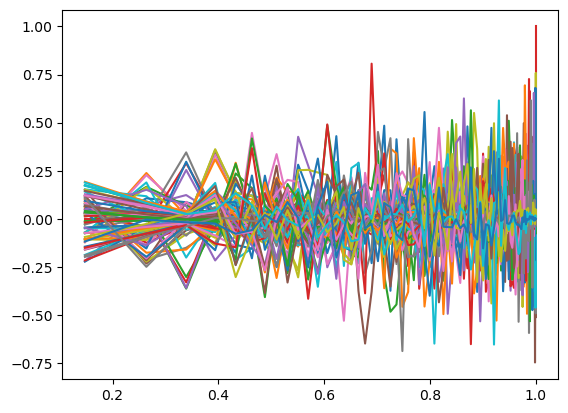

In [55]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
Demo_PCA_df = pca.fit_transform(Demo_Scale_df)
plt.plot( np.cumsum(pca.explained_variance_ratio_) , pca.components_ )
plt.show()



# of components that most explained the variance of data =  81
with max % =  1.0


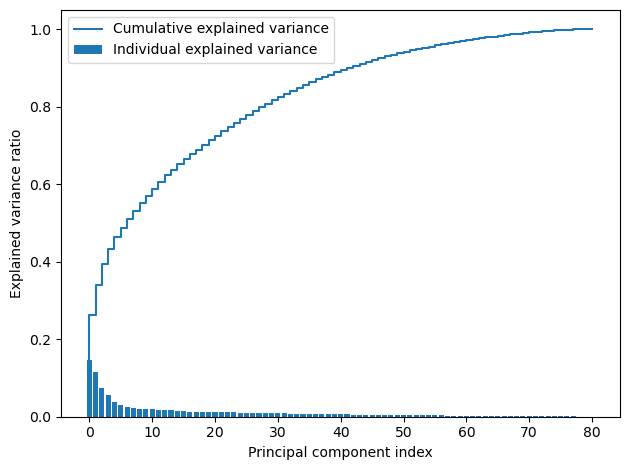

In [56]:
# Investigate the variance accounted for by each principal component.
cum_sum_variance = np.cumsum(pca.explained_variance_ratio_)
print("# of components that most explained the variance of data = ",len(pca.components_) )
print("with max % = " ,max(np.cumsum(pca.explained_variance_ratio_)))
plt.bar(range(0,len(pca.explained_variance_ratio_ )) , pca.explained_variance_ratio_ , label='Individual explained variance')
plt.step(range(0,len(cum_sum_variance)) , cum_sum_variance ,label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



In [57]:
d={'NumberOfComponent' : [] ,  'ExplaindVariance' : []}
for i in range(0,len(pca.components_)): 
    d['NumberOfComponent'].append(i)
    if i == 0:
          d['ExplaindVariance'].append(0)
    else:
        d['ExplaindVariance'].append(max(np.cumsum(pca.explained_variance_ratio_[0:i]).tolist()))
PCA_Components = pd.DataFrame(d, columns=['NumberOfComponent' , 'ExplaindVariance'])

cutoff = 80
print(f'Use Cutoff at Explained Vairnace = [{cutoff}%]')
print('So We Need Number of Components = ' , PCA_Components.query('ExplaindVariance > ' + str(cutoff/100)).NumberOfComponent.iloc[0])
PCA_Components

Use Cutoff at Explained Vairnace = [80%]
So We Need Number of Components =  30


NumberOfComponent  ExplaindVariance
0                   0          0.000000
1                   1          0.147620
2                   2          0.263850
3                   3          0.339091
4                   4          0.393899
..                ...               ...
76                 76          0.997524
77                 77          0.998515
78                 78          0.999308
79                 79          0.999822
80                 80          1.000000

[81 rows x 2 columns]

Explained variance % of data =  80.8 ; using  30  components
891221


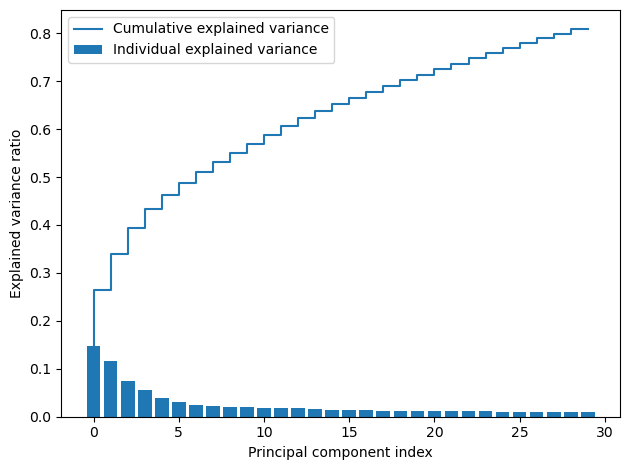

In [58]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components = 30)
pca.feature_names_in_ = df_info.attribute
Demog_df_PCA = pca.fit_transform(Demo_Scale_df)
cum_sum_variance = np.cumsum(pca.explained_variance_ratio_)
print('Explained variance % of data = ', np.round(max(cum_sum_variance) * 100 ,2), "; using " , len(pca.components_) ," components")
print(len(Demog_df_PCA))
plt.bar(range(0,len(pca.explained_variance_ratio_ )) , pca.explained_variance_ratio_ , label='Individual explained variance')
plt.step(range(0,len(cum_sum_variance)) , cum_sum_variance ,label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)
<br>
50 % of Data variance can be explained by 7 featuers and 80 % od data variance can be expalined using 30 features 
in this notebook we are going to use cutoff 95.5% of explained variance so we needs 56 componnents 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [59]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def FeatureWeights(pca,i,df):
    pca_df = pd.DataFrame(pca.components_ , columns = df.columns  , index= pca.get_feature_names_out())
    return pca_df.loc['pca'+str(i)].sort_values(ascending = False)

         
FeatureWeights(pca , 0 , Demo_Scale_df)

PLZ8_BAUMAX           0.192348
WEALTH                0.188608
PLZ8_ANTG3            0.175410
HH_EINKOMMEN_SCORE    0.174318
EWDICHTE              0.171755
                        ...   
KBA05_GBZ            -0.190326
PLZ8_ANTG1           -0.198303
MOBI_REGIO           -0.216221
FINANZ_MINIMALIST    -0.219896
LP_STATUS_GROB       -0.222567
Name: pca0, Length: 81, dtype: float64

In [60]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
FeatureWeights(pca , 1 , Demo_Scale_df)

ALTERSKATEGORIE_GROB     0.238111
FINANZ_VORSORGER         0.227118
SEMIO_ERL                0.189016
RETOURTYP_BK_S           0.166487
SEMIO_LUST               0.163252
                           ...   
FINANZ_ANLEGER          -0.212958
SEMIO_REL               -0.216055
FINANZ_UNAUFFAELLIGER   -0.222515
FINANZ_SPARER           -0.232645
MOVMENT                 -0.249533
Name: pca1, Length: 81, dtype: float64

In [61]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

FeatureWeights(pca , 2,Demo_Scale_df)

SEMIO_VERT           0.345372
SEMIO_KULT           0.296879
SEMIO_SOZ            0.289390
SEMIO_FAM            0.253826
FINANZ_MINIMALIST    0.123548
                       ...   
SEMIO_ERL           -0.201363
SEMIO_KRIT          -0.302610
SEMIO_DOM           -0.330389
SEMIO_KAEM          -0.359328
ANREDE_KZ           -0.362970
Name: pca2, Length: 81, dtype: float64

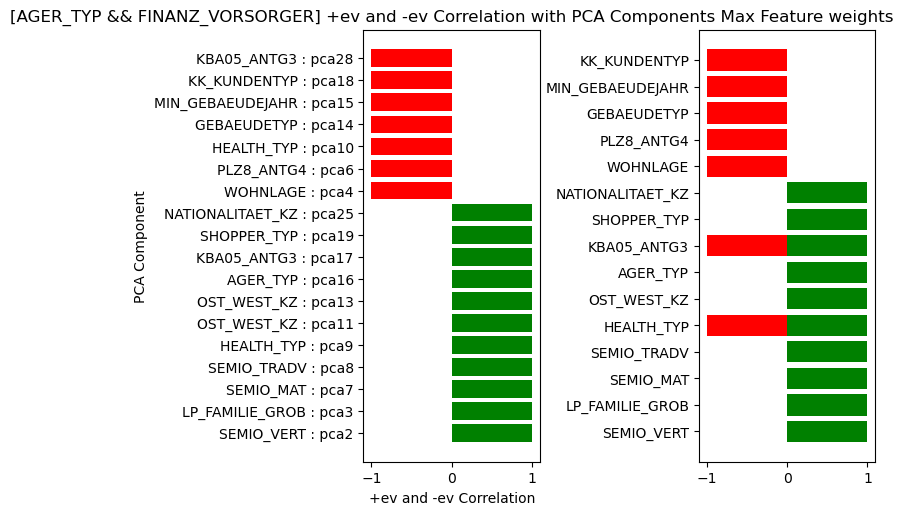

In [62]:
def fetureName(value , df):
    return FeatureWeights(pca , value.replace('pca','') ,df).index[0]
c = pca.components_.copy()
pca_df = pd.DataFrame( c, columns = Demo_Scale_df.columns  , index= pca.get_feature_names_out())
pca_df.iloc[pca_df.values > 0 ] = 1
pca_df.iloc[pca_df.values <= 0 ] = -1

p_index = pca_df.query('FINANZ_VORSORGER == 1 and AGER_TYP == 1').index.values
pindx = []
pindx_=[]
for i in p_index:
    pindx.append(fetureName(i,Demo_Scale_df) + ' : ' +i)
    pindx_.append(fetureName(i,Demo_Scale_df))

n_index = pca_df.query('FINANZ_VORSORGER == -1 and AGER_TYP == -1').index.values
nindx = []
nindx_ = []
for i in n_index:
    nindx.append(fetureName(i,Demo_Scale_df) + ' : ' +i)
    nindx_.append(fetureName(i,Demo_Scale_df))

fig , ax = plt.subplots(1,2)
ax[0].barh(pindx, pca_df.query('FINANZ_VORSORGER == 1 and AGER_TYP == 1').AGER_TYP , color='g')
ax[0].barh(nindx , pca_df.query('FINANZ_VORSORGER == -1 and AGER_TYP == -1').AGER_TYP , color='r')

ax[0].set_title("[AGER_TYP && FINANZ_VORSORGER] +ev and -ev Correlation with PCA Components Max Feature weights")
ax[0].set_xlabel("+ev and -ev Correlation")
ax[0].set_ylabel("PCA Component")

ax[1].barh(pindx_, pca_df.query('FINANZ_VORSORGER == 1 and AGER_TYP == 1').AGER_TYP , color='g')
ax[1].barh(nindx_ , pca_df.query('FINANZ_VORSORGER == -1 and AGER_TYP == -1').AGER_TYP , color='r')


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.9, 
                    hspace=0.9)
plt.show()


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)
<br>
<br>
Increase In [AGER_TYP && FINANZ_VORSORGER] is Correalted with decrease In [Life_Stage , SEMIO_MAT , SEMIO_VERT,..] as in previous graph

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [63]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
from sklearn.cluster import KMeans
    

[57611190.465564005, 50313062.870078936, 45887710.11421099, 43348959.49579292, 41568506.290111184, 39967393.501813516, 38728441.984393, 37790378.98470442, 36919764.83656433, 36116134.554639444, 35525384.04571062] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


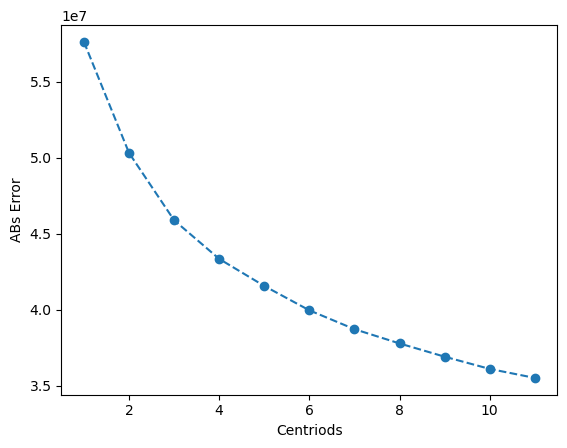

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
for k in range(1,12,1):
    model = KMeans(k)
    model.fit(Demog_df_PCA)
    scores.append(abs(model.score(Demog_df_PCA)))
    #model.fit(Demo_Scale_df)
    #scores.append(abs(model.score(Demo_Scale_df)))
print(scores,list(range(1,12,1)))   
plt.plot(list(range(1,12,1)) , scores , marker ='o', linestyle='dashed')
plt.xlabel('Centriods')
plt.ylabel('ABs Error')
plt.show()

In [65]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

model = KMeans(6)
model.fit(Demog_df_PCA)
demographics_data_Labels = model.predict(Demog_df_PCA)
#model.fit(Demo_Scale_df)
#demographics_data_Labels = model.predict(Demo_Scale_df)
demographics_data_Labels

array([2, 2, 2, ..., 2, 0, 3])

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?) 6

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [66]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [67]:
customers.shape

(191652, 85)

In [68]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
df_info = feat_info.copy()
df = customers.copy()
customer_df_Clean , df_info , Col_Stat , Row_Stat = clean_data(df,df_info)
customer_df_Scale = customer_df_Clean.copy()
print('Customer Data Scalling --> [START]')
print(scaler)
for i in df_info.attribute.tolist():
    m = np.mean(customer_df_Clean[i][~customer_df_Clean[i].isin([np.nan])])
    customer_df_Clean[i].fillna(m , inplace=True)
    
customer_df_Scale=scaler.transform(customer_df_Clean) 
customer_df_Scale = pd.DataFrame(customer_df_Scale , columns = df_info.attribute.values) 
print('Customer Data Scalling <-- [END]') 
print(customer_df_Scale.DECADE.describe())

print('Customer Data PCA --> [START]')
Customer_df_PCA = pca.transform(customer_df_Scale)
print('Customer Data PCA <-- [END]')   
print(Customer_df_PCA.shape)
Customer_data_Labels = model.predict(Customer_df_PCA)
#Customer_data_Labels = model.predict(customer_df_Scale)
print(Customer_data_Labels)

Prepare Row and column Stats for DataFrame --> (START)
Prepare Row and column Stats for DataFrame <-- (END)
Set NaN Values for all unkown Values in DataFrame --> (START)
Set NaN Values for all unkown Values in DataFrame <-- (END)
Remove selected columns --> (START)
Drop Columns :  ['SOHO_KZ' 'TITEL_KZ' 'ANZ_TITEL' 'ANZ_HH_TITEL' 'KBA05_ANTG4']  From Data DataFrame
Drop Columns : ['SOHO_KZ' 'TITEL_KZ' 'ANZ_TITEL' 'ANZ_HH_TITEL' 'KBA05_ANTG4']  From Information DataFrame
Remove selected columns --> (END)
Remove selected Rows with [BadValuePercentage >= 80]  --> (START)
Remove selected Rows with [BadValuePercentage >= 80]  <-- (END)
ReEncoding Categorical Binary varaibles ---> (Start)
Decode Column [OST_WEST_KZ]: 
Form List of Values :  ['W' nan 'O']
To List of Values [1 nan 0]
ReEncoding Categorical Binary varaibles ---> (END)
ReEncoding Categorical multi level varaibles ---> (Start)
Decode Column [CAMEO_DEU_2015]: 
Form List of Values :  ['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A'

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

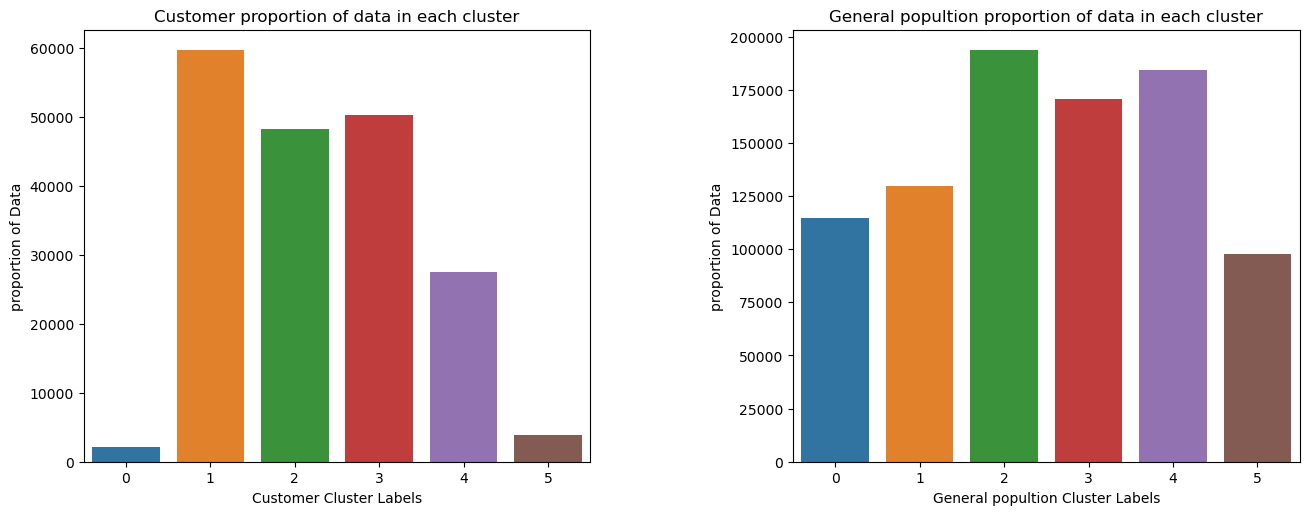

In [69]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#print(len(Customer_data_Labels) , len(demographics_data_Labels))
figure ,ax = plt.subplots(1,2)
sns.countplot(x=Customer_data_Labels , ax=ax[0] )
sns.countplot(x=demographics_data_Labels , ax=ax[1] )

ax[0].set_title("Customer proportion of data in each cluster")
ax[1].set_title("General popultion proportion of data in each cluster")
ax[0].set_xlabel("Customer Cluster Labels")
ax[0].set_ylabel("proportion of Data")
ax[1].set_xlabel("General popultion Cluster Labels")
ax[1].set_ylabel("proportion of Data")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=2, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.3)
plt.show()




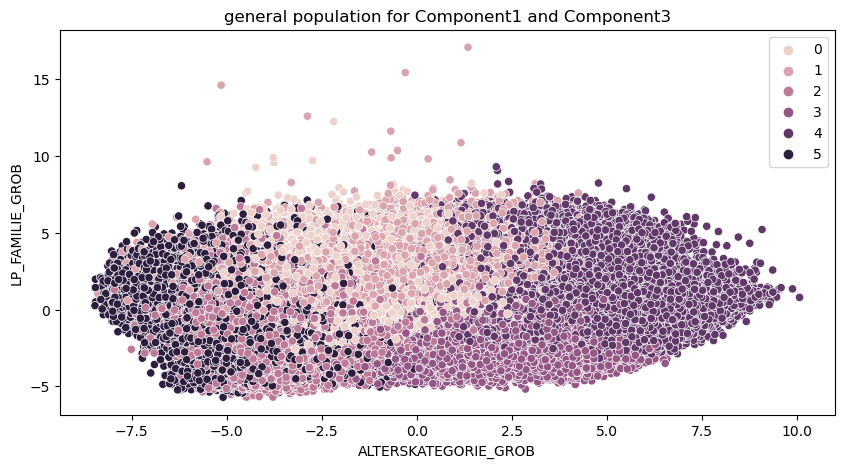

In [70]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
x,y = 1,3
full_kmean_PCA_Demog_df = pd.concat([azdias,pd.DataFrame(Demog_df_PCA)],axis=1)
full_kmean_PCA_Demog_df['Cluster'] = demographics_data_Labels
X = full_kmean_PCA_Demog_df[x]
Y = full_kmean_PCA_Demog_df[y]
plt.figure(figsize = (10,5))
sns.scatterplot(x= X ,y= Y , hue=demographics_data_Labels)
plt.title(f"general population for Component{x} and Component{y}")
plt.xlabel(f"{FeatureWeights(pca , x , Demo_Scale_df).index[0]}")
plt.ylabel(f"{FeatureWeights(pca , y , Demo_Scale_df).index[0]}")
plt.show()


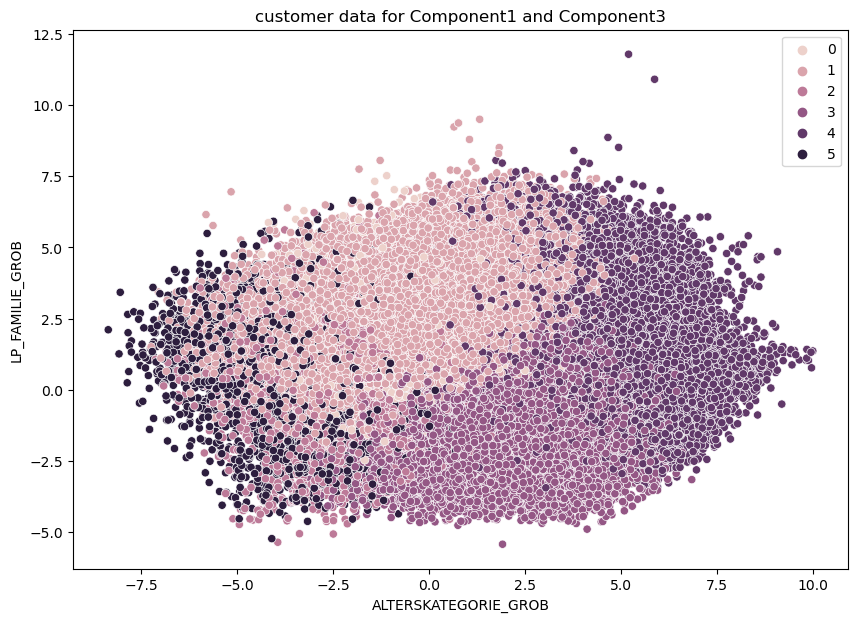

In [72]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
x,y = 1 ,3
full_kmean_PCA_Customer_df = pd.concat([customers,pd.DataFrame(Customer_df_PCA)],axis=1)
full_kmean_PCA_Customer_df['Cluster'] = Customer_data_Labels
X = full_kmean_PCA_Customer_df[x]
Y = full_kmean_PCA_Customer_df[y]
plt.figure(figsize = (10,7))
sns.scatterplot(x= X ,y= Y , hue=Customer_data_Labels)
plt.title(f"customer data for Component{x} and Component{y}")
plt.xlabel(f"{FeatureWeights(pca , x , customer_df_Scale).index[0]}")
plt.ylabel(f"{FeatureWeights(pca , y , customer_df_Scale).index[0]}")
plt.show()

191652


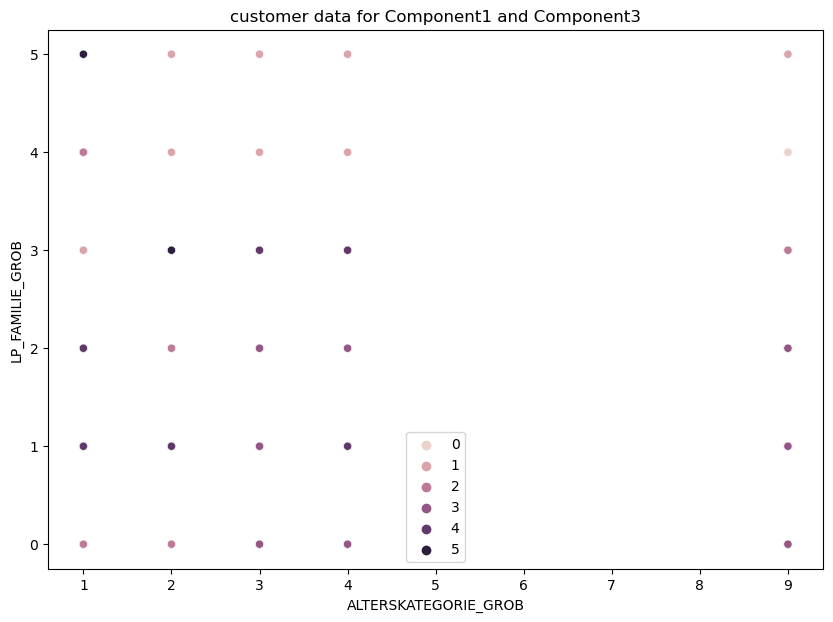

In [75]:
#full_kmean_PCA_Customer_df = pd.concat([customers,pd.DataFrame(Customer_df_PCA)],axis=1)
#full_kmean_PCA_Customer_df['Cluster'] = Customer_data_Labels
print(len(Customer_data_Labels))
x,y = 1,3
c1 = FeatureWeights(pca , x , Customer_df_PCA).index[0]
c2 = FeatureWeights(pca , y , Customer_df_PCA).index[0]
X = customers[c1]
Y = customers[c2]
plt.figure(figsize = (10,7))
sns.scatterplot(x= X ,y= Y , hue=Customer_data_Labels)
plt.title(f"customer data for Component{x} and Component{y}")
plt.xlabel(f"{FeatureWeights(pca , x , customer_df_Scale).index[0]}")
plt.ylabel(f"{FeatureWeights(pca , y , customer_df_Scale).index[0]}")
plt.show()

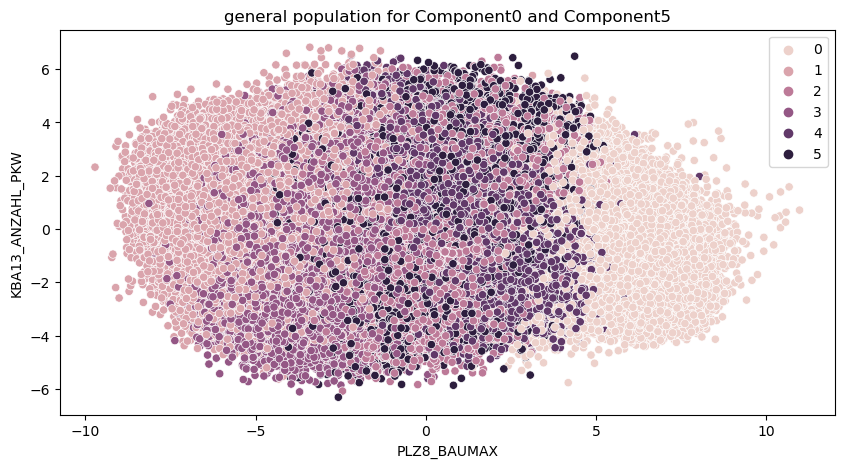

In [76]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

x,y = 0,5
full_kmean_PCA_Demog_df = pd.concat([azdias,pd.DataFrame(Demog_df_PCA)],axis=1)
full_kmean_PCA_Demog_df['Cluster'] = demographics_data_Labels
X = full_kmean_PCA_Demog_df[x]
Y = full_kmean_PCA_Demog_df[y]
plt.figure(figsize = (10,5))
sns.scatterplot(x= X ,y= Y , hue=demographics_data_Labels)
plt.title(f"general population underrepresented for Component{x} and Component{y}")
plt.xlabel(f"{FeatureWeights(pca , x , Demo_Scale_df).index[0]}")
plt.ylabel(f"{FeatureWeights(pca , y , Demo_Scale_df).index[0]}")
plt.show()

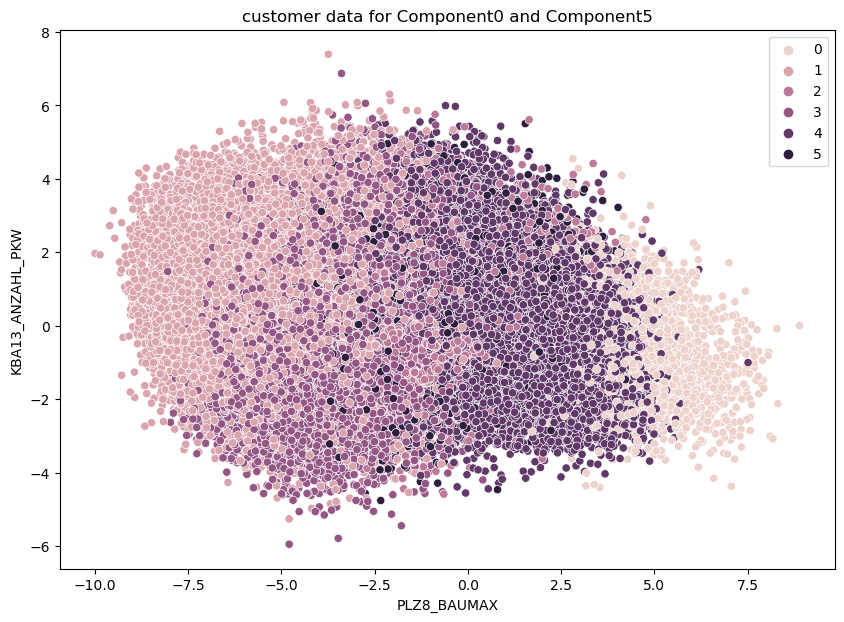

In [77]:
x,y = 0 ,5
full_kmean_PCA_Customer_df = pd.concat([customers,pd.DataFrame(Customer_df_PCA)],axis=1)
full_kmean_PCA_Customer_df['Cluster'] = Customer_data_Labels
X = full_kmean_PCA_Customer_df[x]
Y = full_kmean_PCA_Customer_df[y]
plt.figure(figsize = (10,7))
sns.scatterplot(x= X ,y= Y , hue=Customer_data_Labels)
plt.title(f"customer data underrepresented for Component{x} and Component{y}")
plt.xlabel(f"{FeatureWeights(pca , x , customer_df_Scale).index[0]}")
plt.ylabel(f"{FeatureWeights(pca , y , customer_df_Scale).index[0]}")
plt.show()

191652


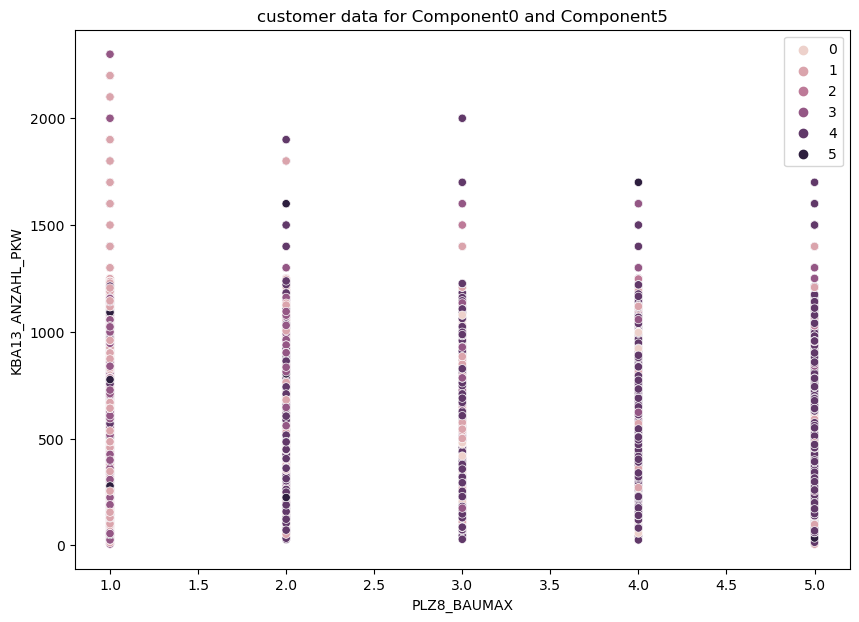

In [80]:
#full_kmean_PCA_Customer_df = pd.concat([customers,pd.DataFrame(Customer_df_PCA)],axis=1)
#full_kmean_PCA_Customer_df['Cluster'] = Customer_data_Labels
print(len(Customer_data_Labels))
x,y = 0,5
c1 = FeatureWeights(pca , x , customer_df_Scale).index[0]
c2 = FeatureWeights(pca , y , customer_df_Scale).index[0]
X = customers[c1]
Y = customers[c2]
plt.figure(figsize = (10,7))
sns.scatterplot(x= X ,y= Y , hue=Customer_data_Labels)
plt.title(f"customer data for Component{x} and Component{y}")
plt.xlabel(f"{FeatureWeights(pca , x , customer_df_Scale).index[0]}")
plt.ylabel(f"{FeatureWeights(pca , y , customer_df_Scale).index[0]}")
plt.show()

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

A) relatively unpopular with the company
-Most common building type within the PLZ8 region
- 1: mainly 1-2 family homes
- Number of cars in the PLZ8 region
- 5: mainly business buildings

B) relatively popular
- 4: family (maps to 6-8 in fine scale)
- 5: multiperson household (maps to 9-11 in fine scale)
-Estimated age based on given name analysis
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.